# A Deep Learning Approach for determining the influence of

# Post-Impressionism on Modern Art

This project will contain code for a Deep learning project to search for influential ties between Post-Impressionist paintings and works from subsequent movements. The overview of the project is as follows:

1. Extract visual features from the dataset using a pretrained VGG16 model trained on ImageNet and reduce dimensionality using PCA.

2. Use the feature vectors to calculate the visual distances between Post-Impressionism and paintings from subsequent Modern Art movements.

3. Visualize the results using histograms, density plots and image plots.

I will be comparing the artwork of Post-Impressionist artists with the the artwork produced in subsequent movements. I will be comparing (1) Post-Impressionist art with:
(2) Fauvism; (3) Cubism; (4) Futurism; (5) Expressionism; (6) Dada; (7) Surrealism; (8) Abstract Expressionism; and (9) Pop Art. This seems appropriate since these are the most significant and influential movements in Modern Art. It also benefits the progress of the project with regard to time constraints.

## Import libraries

In [1]:
# Preprocessing steps from: https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

# loading and preprocessing images  
import pathlib
import PIL
from PIL import Image
import glob
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# models and dimension reduction
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.decomposition import PCA

# distance measures, graphs etc.
from scipy.spatial import distance
from collections import Counter
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import pickle
import seaborn as sea

## Pre-processing Files to Image Dataset

The dataset for this project was sourced from cs-chan's ARTGAN repository on GitHub (https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset). It is a collection of painting images from wikiart.org organised by Artist, Style and Genre. However, for this project only the zip file organized the artwork into their individual movements was required. 
On closer inspection of the dataset, Surrealism and Futurism were not found to be present. Therefore, these movements were omitted from the initial stages of the project. The possibility of later employing web-scraping to obtain these images directly from wikiart.org was considered if time allowed.

In [2]:
print(os.listdir("wikiart"))

['Abstract_Expressionism', 'Cubism', 'Expressionism', 'Fauvism', 'Pop_Art', 'Post_Impressionism']


The next stage was to preprocess the images in the dataset so they could be used in the CNN model. 
The following pre-processing pipeline is based on the TensorFlow tutorial for loading and pre-processing images: https://www.tensorflow.org/tutorials/load_data/images

In [3]:
art_dir = pathlib.Path("wikiart")
list_ds = tf.data.Dataset.list_files(str(art_dir/'*/*'))

In [4]:
for file in list_ds.take(5):
  print(file.numpy())

b'wikiart\\Abstract_Expressionism\\milton-resnick_composition-1963.jpg'
b'wikiart\\Expressionism\\max-beckmann_quappi-in-pink.jpg'
b'wikiart\\Cubism\\olexandr-archipenko_two-figures.jpg'
b'wikiart\\Expressionism\\miriam-schapiro_she-flies-through-the-air-with-the-greatest-of-ease.jpg'
b'wikiart\\Abstract_Expressionism\\arthur-pinajian_untitled-landscape-woodstock-no-4398-1962.jpg'


In [5]:
class_names = np.array(sorted([item.name for item in art_dir.glob('*')]))
print(class_names)

['Abstract_Expressionism' 'Cubism' 'Expressionism' 'Fauvism' 'Pop_Art'
 'Post_Impressionism']


In [6]:
image_count = len(list(art_dir.glob('*/*.jpg')))
print(image_count)

20620


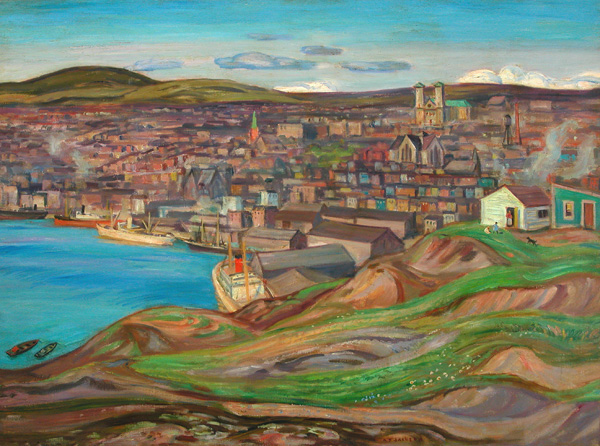

In [7]:
# Load an image from dataset
postimp = list(art_dir.glob("Post_Impressionism/*"))
PIL.Image.open(str(postimp[7]))

In [8]:
# From: https://www.tensorflow.org/tutorials/load_data/images

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [9]:
# Modified from: https://www.tensorflow.org/tutorials/load_data/images

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image so that it matches the input size of VGG16 model
  return tf.image.resize(img, [224,224])

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    path = file_path
    return img, label, path

In [10]:
dataset = list_ds.map(process_path)

In [11]:
for image, label, path in dataset.take(1):
    print("Image Shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("File Name: ", path.numpy())

Image Shape:  (224, 224, 3)
Label:  2
File Name:  b'wikiart\\Expressionism\\marcelle-cahn_nu-sur-fond-bleu-1924.jpg'


In [12]:
# Finally batch the dataset
dataset = dataset.batch(batch_size=80)

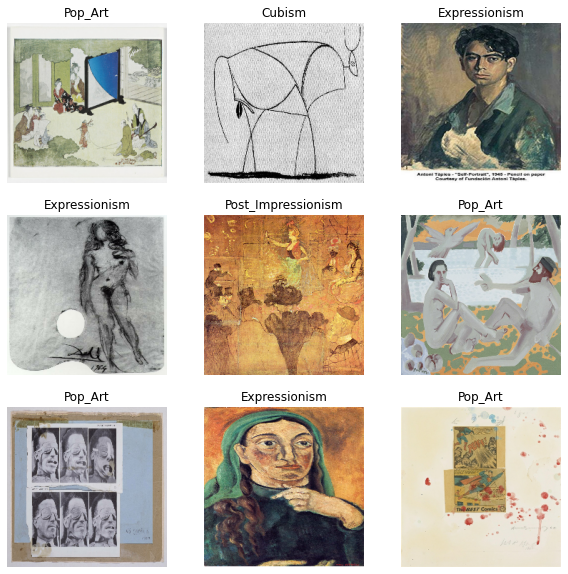

In [13]:
# From: https://towardsdatascience.com/introduction-to-keras-part-one-data-loading-43b9c015e27c
# Load some images from the dataset

plt.figure(figsize=(10,10))
for images, labels, files in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show

The images in the dataset are now represented as tensors in batches of 100 whose input size match the required input size of the VGG16 model to be used for feature extraction. These tensor batches are accompanied by an array of labels that match each image tensor to their class and an array of file names that matches each tensor to the image file.

## Loading the Model

In [82]:
# Resources: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
#            https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [44]:
# Load the pre-trained model and check it out
VGG16_pretrained = VGG16(weights="imagenet")
VGG16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

I have imported the VGG16 model from Keras (Tensorflow backend), and plan to used the model with weights pre-trained on ImageNet which is a much larger dataset than the one that I will be using in my experiments. This allows me to make use of transfer learning methods in the feature extraction stage which will hopefully provide better results. 

The next step is to cut the model after the flatten stage. This terminates the model just before the fully connected layers with 
the neural networks since we only need the model to output the feature vectors generated for each painting in the dataset. 

In [45]:
VGG16_pretrained = Model(inputs=VGG16_pretrained.inputs, outputs= VGG16_pretrained.layers[-4].output)
VGG16_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Feature extraction and dimension reduction

With the data pre-processed into an image dataset suitable for the model, the next step is to load the dataset batch-wise into the model and extract the features for each painting.

In [47]:
# Load the data into the model in batches and for each image output a list of features, a list of file names and 
# a list of their corresponding labels

pca = PCA(n_components=50, random_state = 7)

feature_list = []
label_list = []
file_list = []

for image_batch, label_batch, file_batch in dataset:

    file_list.extend(file_batch)
    label_list.extend(label_batch)
    features = VGG16_pretrained(image_batch)
    features_50 = pca.fit_transform(features)
    feature_list.extend(features_50)

In [70]:
movement_list = []
for label in label_list:
    movement_list.extend(str(label.numpy()))

In [80]:
str(file_list[0].numpy())

"b'wikiart\\\\Post_Impressionism\\\\roger-fry_view-on-the-cote-d-azur-menton-1916.jpg'"

In [91]:
filename_list = []
for file in file_list:
    filename_list.append(file.numpy())

After converting them to numpy format the lists of artwork feature vectors and their corresponding file names and movement names are saved in numpy files so they can be used in later stages.

In [68]:
np.save('art_feat.npy', feature_list, allow_pickle=True)

In [69]:
np.save('art_movements.npy', movement_list, allow_pickle=True)

In [93]:
np.save('art_filenames.npy', filename_list, allow_pickle=True )

## Preliminary Analysis

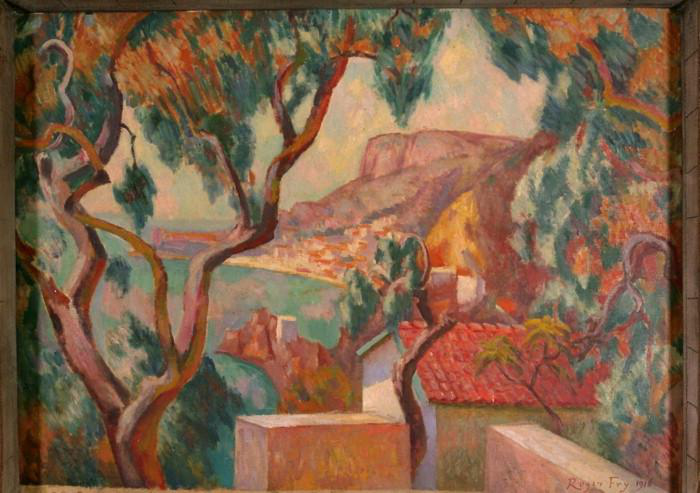

In [14]:
# Load image from saved filenames
array = np.load('art_filenames.npy')
PIL.Image.open(array[0])

In [15]:
# Load the features, labels and file names
featurevecs = np.load("art_feat.npy")
movements = np.load("art_movements.npy")
filenames = np.load("art_filenames.npy")

In [16]:
filenames

array([b'wikiart\\Post_Impressionism\\roger-fry_view-on-the-cote-d-azur-menton-1916.jpg',
       b'wikiart\\Expressionism\\ernst-ludwig-kirchner_female-nudes-in-a-atelier.jpg',
       b'wikiart\\Abstract_Expressionism\\joe-goode_pollution-r2-1995.jpg',
       ...,
       b'wikiart\\Expressionism\\lyonel-feininger_gelmeroda-v-1916.jpg',
       b'wikiart\\Post_Impressionism\\paul-gauguin_the-morning-1892.jpg',
       b'wikiart\\Cubism\\pyotr-konchalovsky_still-life-lotus-1917.jpg'],
      dtype='|S145')

In [17]:
# Convert movement list from strings to integers 
movements = [int(movement) for movement in movements]

In [18]:
# Get a dictionary that lists indices of paintings in each movement
movements_dict = {}
for i in range(len(movements)):
    if movements[i] in movements_dict.keys():
        movements_dict[movements[i]].append(i)
    else:
        movements_dict[movements[i]] = [i]

In [19]:
20620 - len(list(movements_dict.values())[0])

14170

In [20]:
def get_centroid(cluster): # A function that calculates the mean of a set of data points to find their centroid.
    cluster_size = len(cluster)
    centroid = sum(cluster)/cluster_size
    return centroid

In [21]:
# get centroids from original feature vecs and the Euclidian distance 
centroids = {}
for m in movements_dict.keys():
    m_indices = movements_dict[m]
    m_cluster = featurevecs[m_indices]
    centroids[m] = get_centroid(m_cluster)

In [22]:
# Compute the Euclidian distances between Post-Impressionism centroid and that of each movement
for movement in centroids.keys():
    if movement != 5:
        dist = distance.euclidean(centroids[5], centroids[movement])
        print("Movement: ", class_names[movement])
        print("Distance from Post-Impressionism: ", dist)
    else:
        continue

Movement:  Expressionism
Distance from Post-Impressionism:  73.60639812788682
Movement:  Abstract_Expressionism
Distance from Post-Impressionism:  44.669040520030926
Movement:  Cubism
Distance from Post-Impressionism:  142.5258717151175
Movement:  Pop_Art
Distance from Post-Impressionism:  139.93684635604293
Movement:  Fauvism
Distance from Post-Impressionism:  132.36341926721798


In [23]:
# Compute the cosine distances between Post-Impressionism centroid and that of each movement
for movement in centroids.keys():
    if movement != 5:
        dist =  1 - distance.cosine(centroids[5], centroids[movement])
        print("Movement: ", class_names[movement])
        print("Distance from Post-Impressionism: ", dist)
    else:
        continue

Movement:  Expressionism
Distance from Post-Impressionism:  -0.6429679116063407
Movement:  Abstract_Expressionism
Distance from Post-Impressionism:  0.7339444502476199
Movement:  Cubism
Distance from Post-Impressionism:  -0.9518597816630758
Movement:  Pop_Art
Distance from Post-Impressionism:  -0.8868875201034387
Movement:  Fauvism
Distance from Post-Impressionism:  -0.8331689376076792


In [24]:
# Compute the cosine distances between Post-Impressionism centroid and that of each movement
for movement in centroids.keys():
    if movement != 5:
        dist = distance.correlation(centroids[5], centroids[movement])
        print("Movement: ", class_names[movement])
        print("Distance from Post-Impressionism: ", dist)
    else:
        continue

Movement:  Expressionism
Distance from Post-Impressionism:  1.6600530377384588
Movement:  Abstract_Expressionism
Distance from Post-Impressionism:  0.28251283588204956
Movement:  Cubism
Distance from Post-Impressionism:  1.9428072547657746
Movement:  Pop_Art
Distance from Post-Impressionism:  1.866896850791148
Movement:  Fauvism
Distance from Post-Impressionism:  1.8036097005698062


Comparing the distance measures, the results are very similar for both cosine and correlation distance. Euclidean presents the same overall distance pattern.

## Distance between Post-Impressionism and individual paintings per movement

Now take a closer look at the distances of individual paintings in each movement from the Post-Impressionism centroid. This gathers the distributions of paintings in each movement according to their visual closeness or similarity to Post-Impressionism (represented by its centroid in the feature space).

In [25]:
movement_dist_cos = {}

for movement in movements_dict.keys():
    if movement in movement_dist_cos.keys():
        continue
    elif movement == 5:
        continue
    else:
        movement_dist_cos[movement] = [distance.cosine(centroids[5], featurevecs[painting]) for painting in movements_dict[movement]]

In [26]:
movement_dist_eu = {}

for movement in movements_dict.keys():
    if movement in movement_dist_eu.keys():
        continue
    elif movement == 5:
        continue
    else:
        movement_dist_eu[movement] = [distance.euclidean(centroids[5], featurevecs[painting]) for painting in movements_dict[movement]]

In [27]:
movement_dist_corr = {}

for movement in movements_dict.keys():
    if movement in movement_dist_corr.keys():
        continue
    elif movement == 5:
        continue
    else:
        movement_dist_corr[movement] = [distance.correlation(centroids[5], featurevecs[painting]) for painting in movements_dict[movement]]

Plot distances in histograms to visualize the distribution of distances between Post-Impressionism and paintings in other movements.

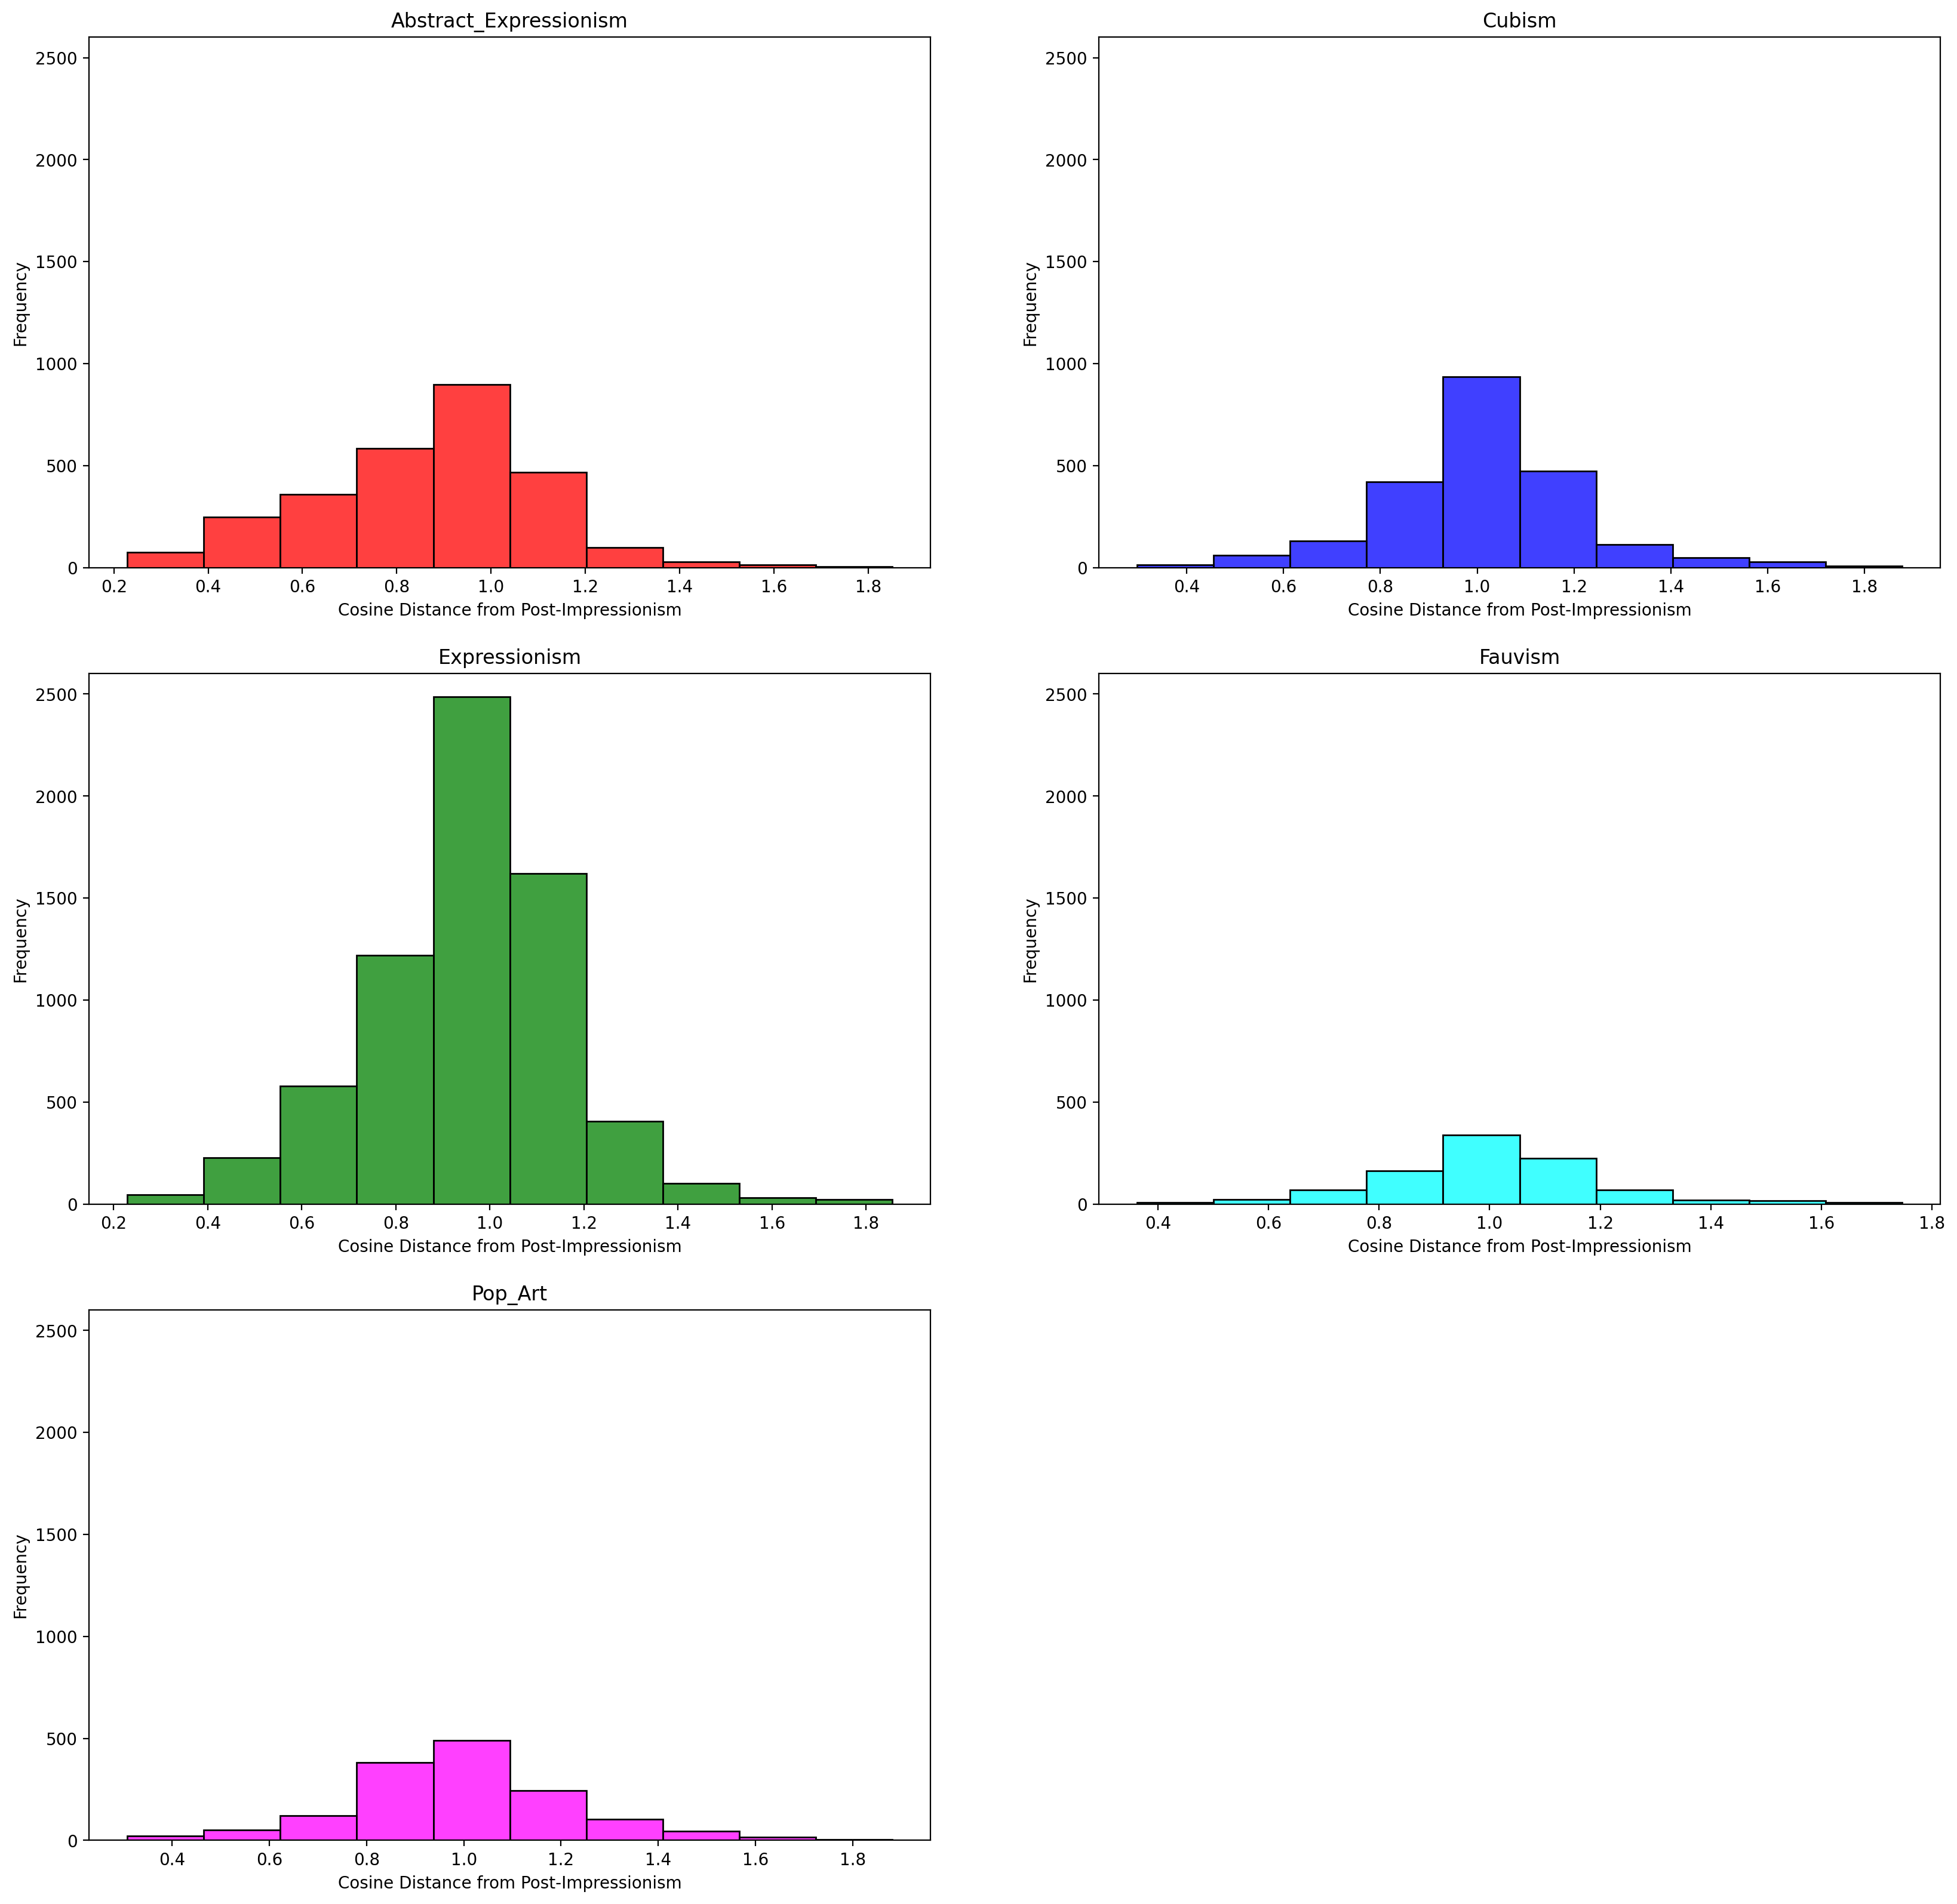

In [28]:
# Plot histograms 
colormap = ['red', 'blue', 'green', 'cyan', 'magenta']
plt.figure(figsize=(20,20), dpi=200)
# Plot histogram for each movement
for movement in range(len(movement_dist_cos.keys())):
    plt.subplot(3,2, movement+1)
    xs = movement_dist_cos[movement]
    color = colormap[movement]
    sea.histplot(xs, bins = 10, color=color, edgecolor='black')
    plt.xlabel('Cosine Distance from Post-Impressionism')
    plt.ylabel('Frequency')
    plt.title(class_names[movement])
    plt.ylim(0, 2600)    

Plot stacked histograms to compare distance distributions of each movement more closely.

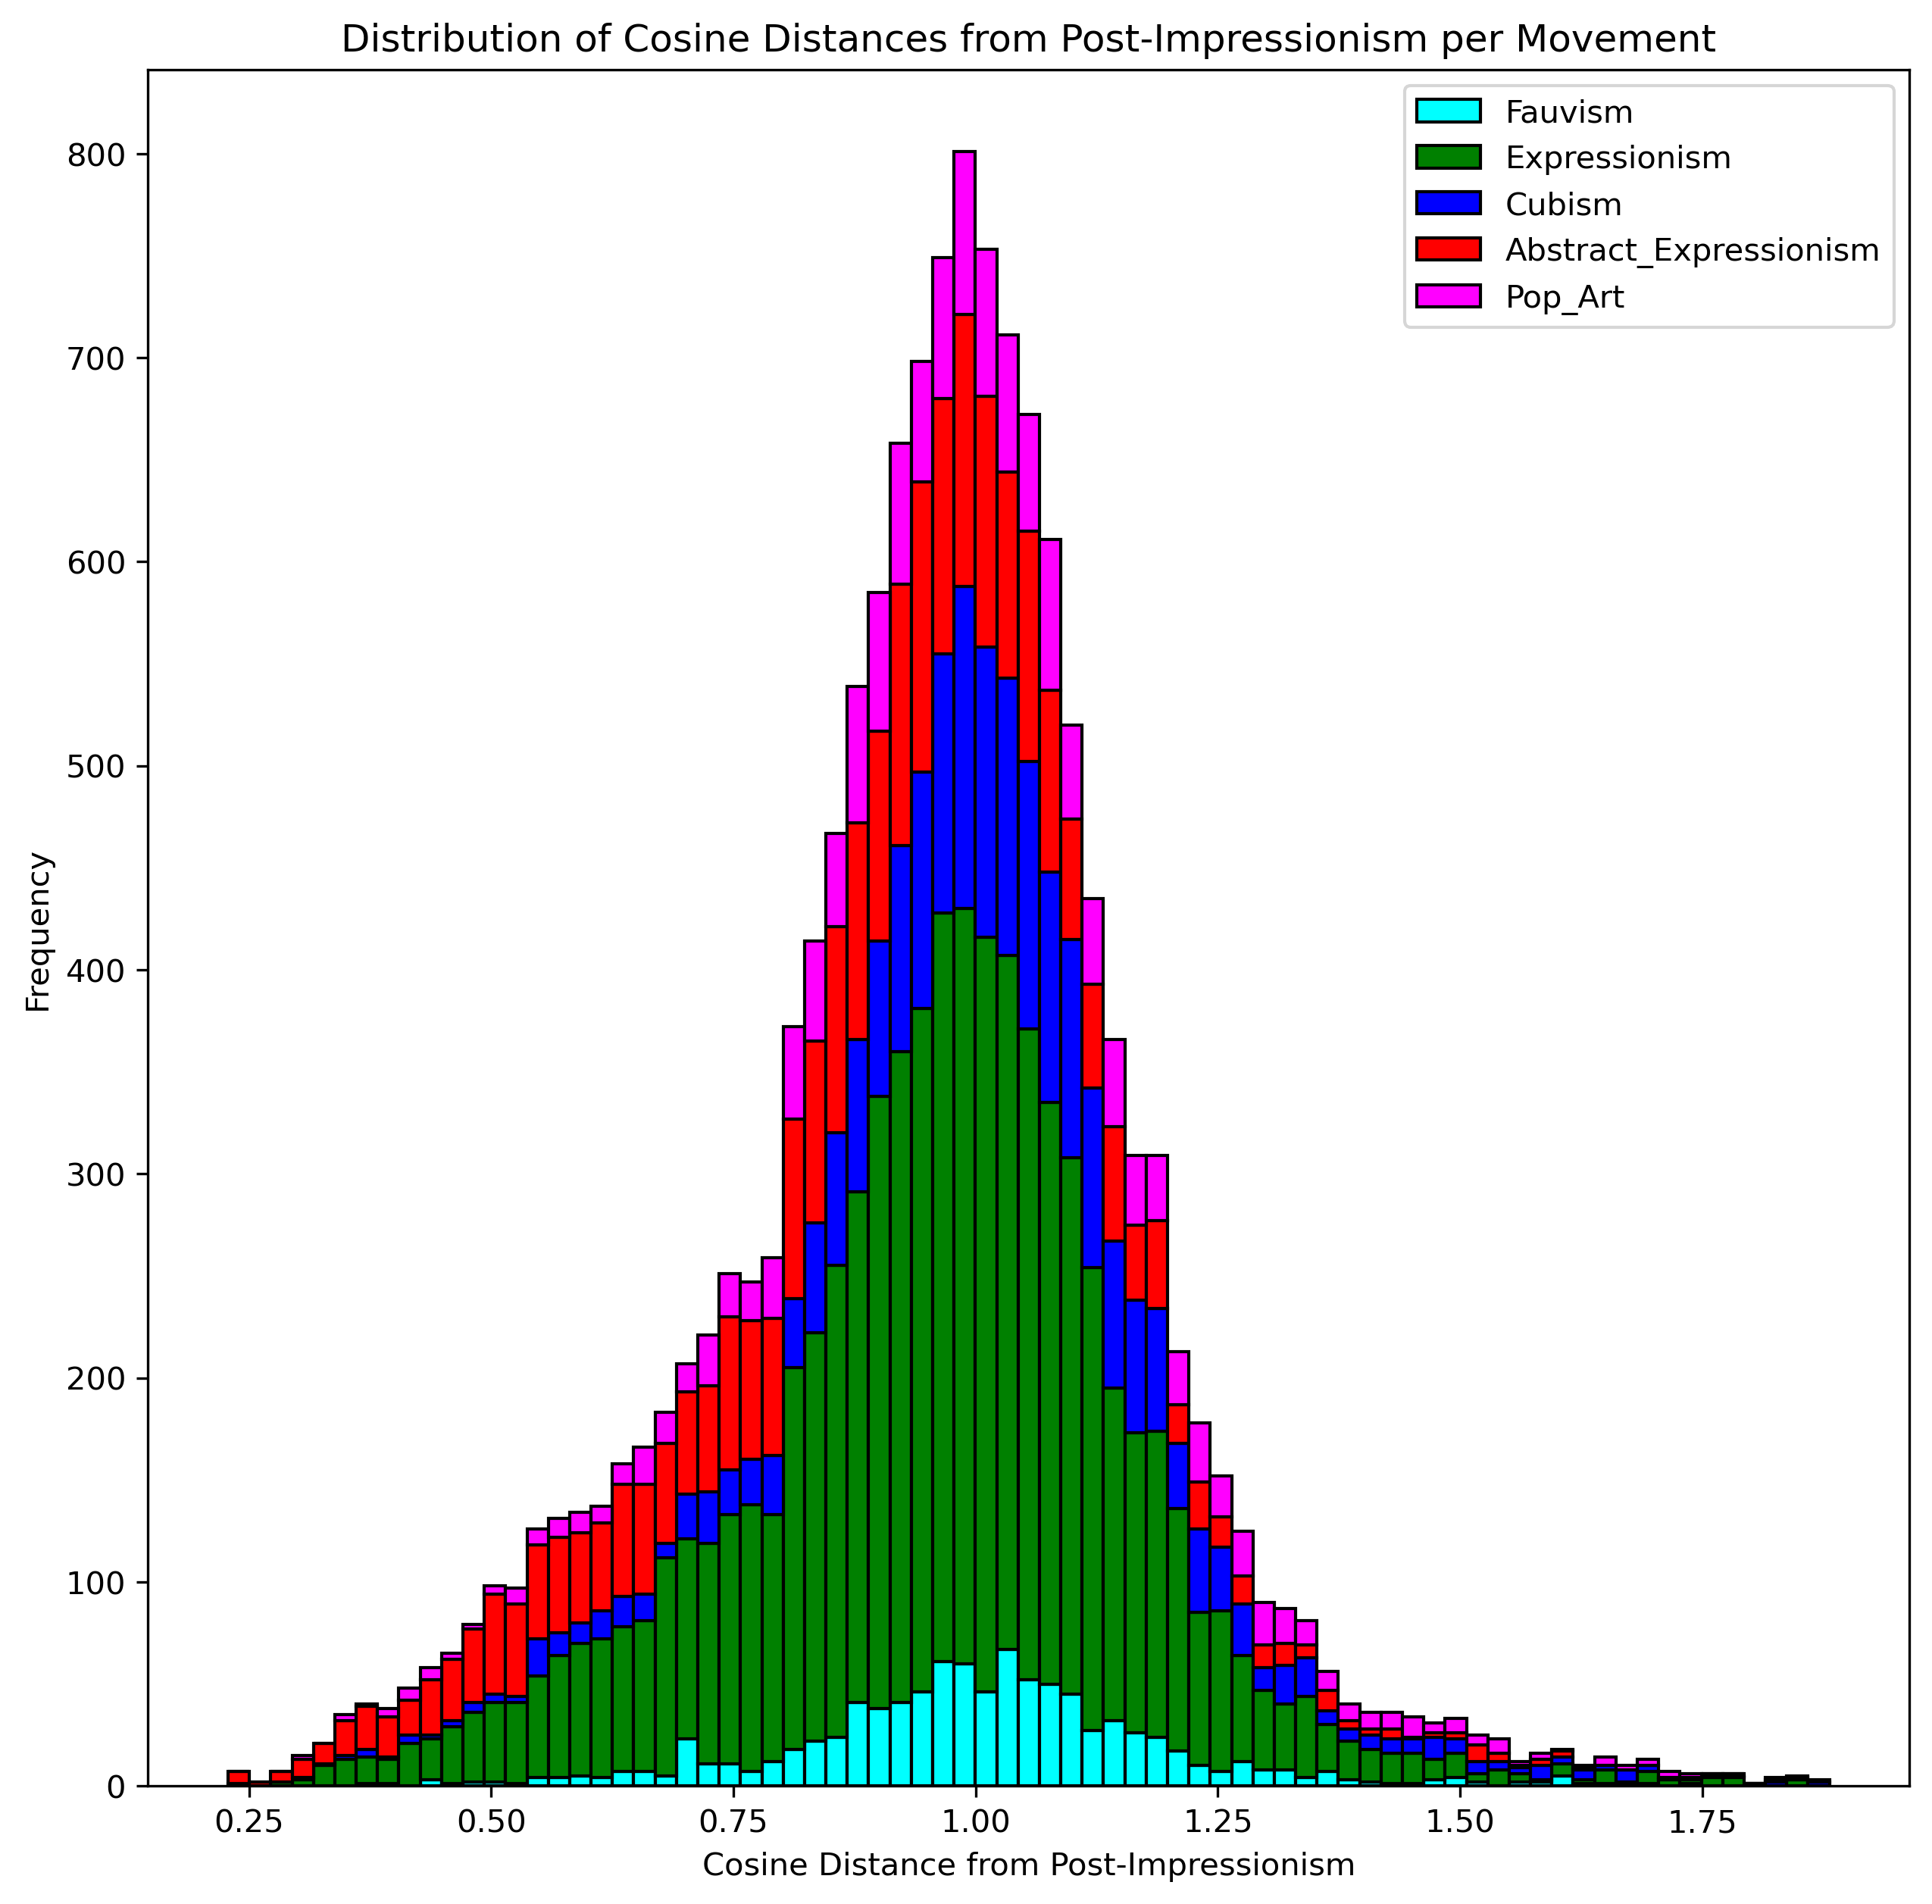

In [29]:
# Plot a stacked histogram for cosine distances
chrono_movements = ['Fauvism', 'Expressionism', 'Cubism', 'Abstract_Expressionism', 'Pop_Art']
colormap = ['cyan', 'green', 'blue', 'red', 'magenta']
plt.figure(figsize=(10,10), dpi=300)
xs = []
label = []
for movement in range(len(movement_dist_cos.keys())):
    
    # arrange movements in chronological order for better comparison between measurements
    index = list(class_names).index(chrono_movements[movement])
    data = movement_dist_cos[index]
    xs.append(data)
    label.append(class_names[index])
    
    
plt.hist(xs, bins = 75, color=colormap, edgecolor='black', label=label, histtype='barstacked', stacked=True)
plt.xlabel('Cosine Distance from Post-Impressionism')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Distances from Post-Impressionism per Movement')
plt.legend()

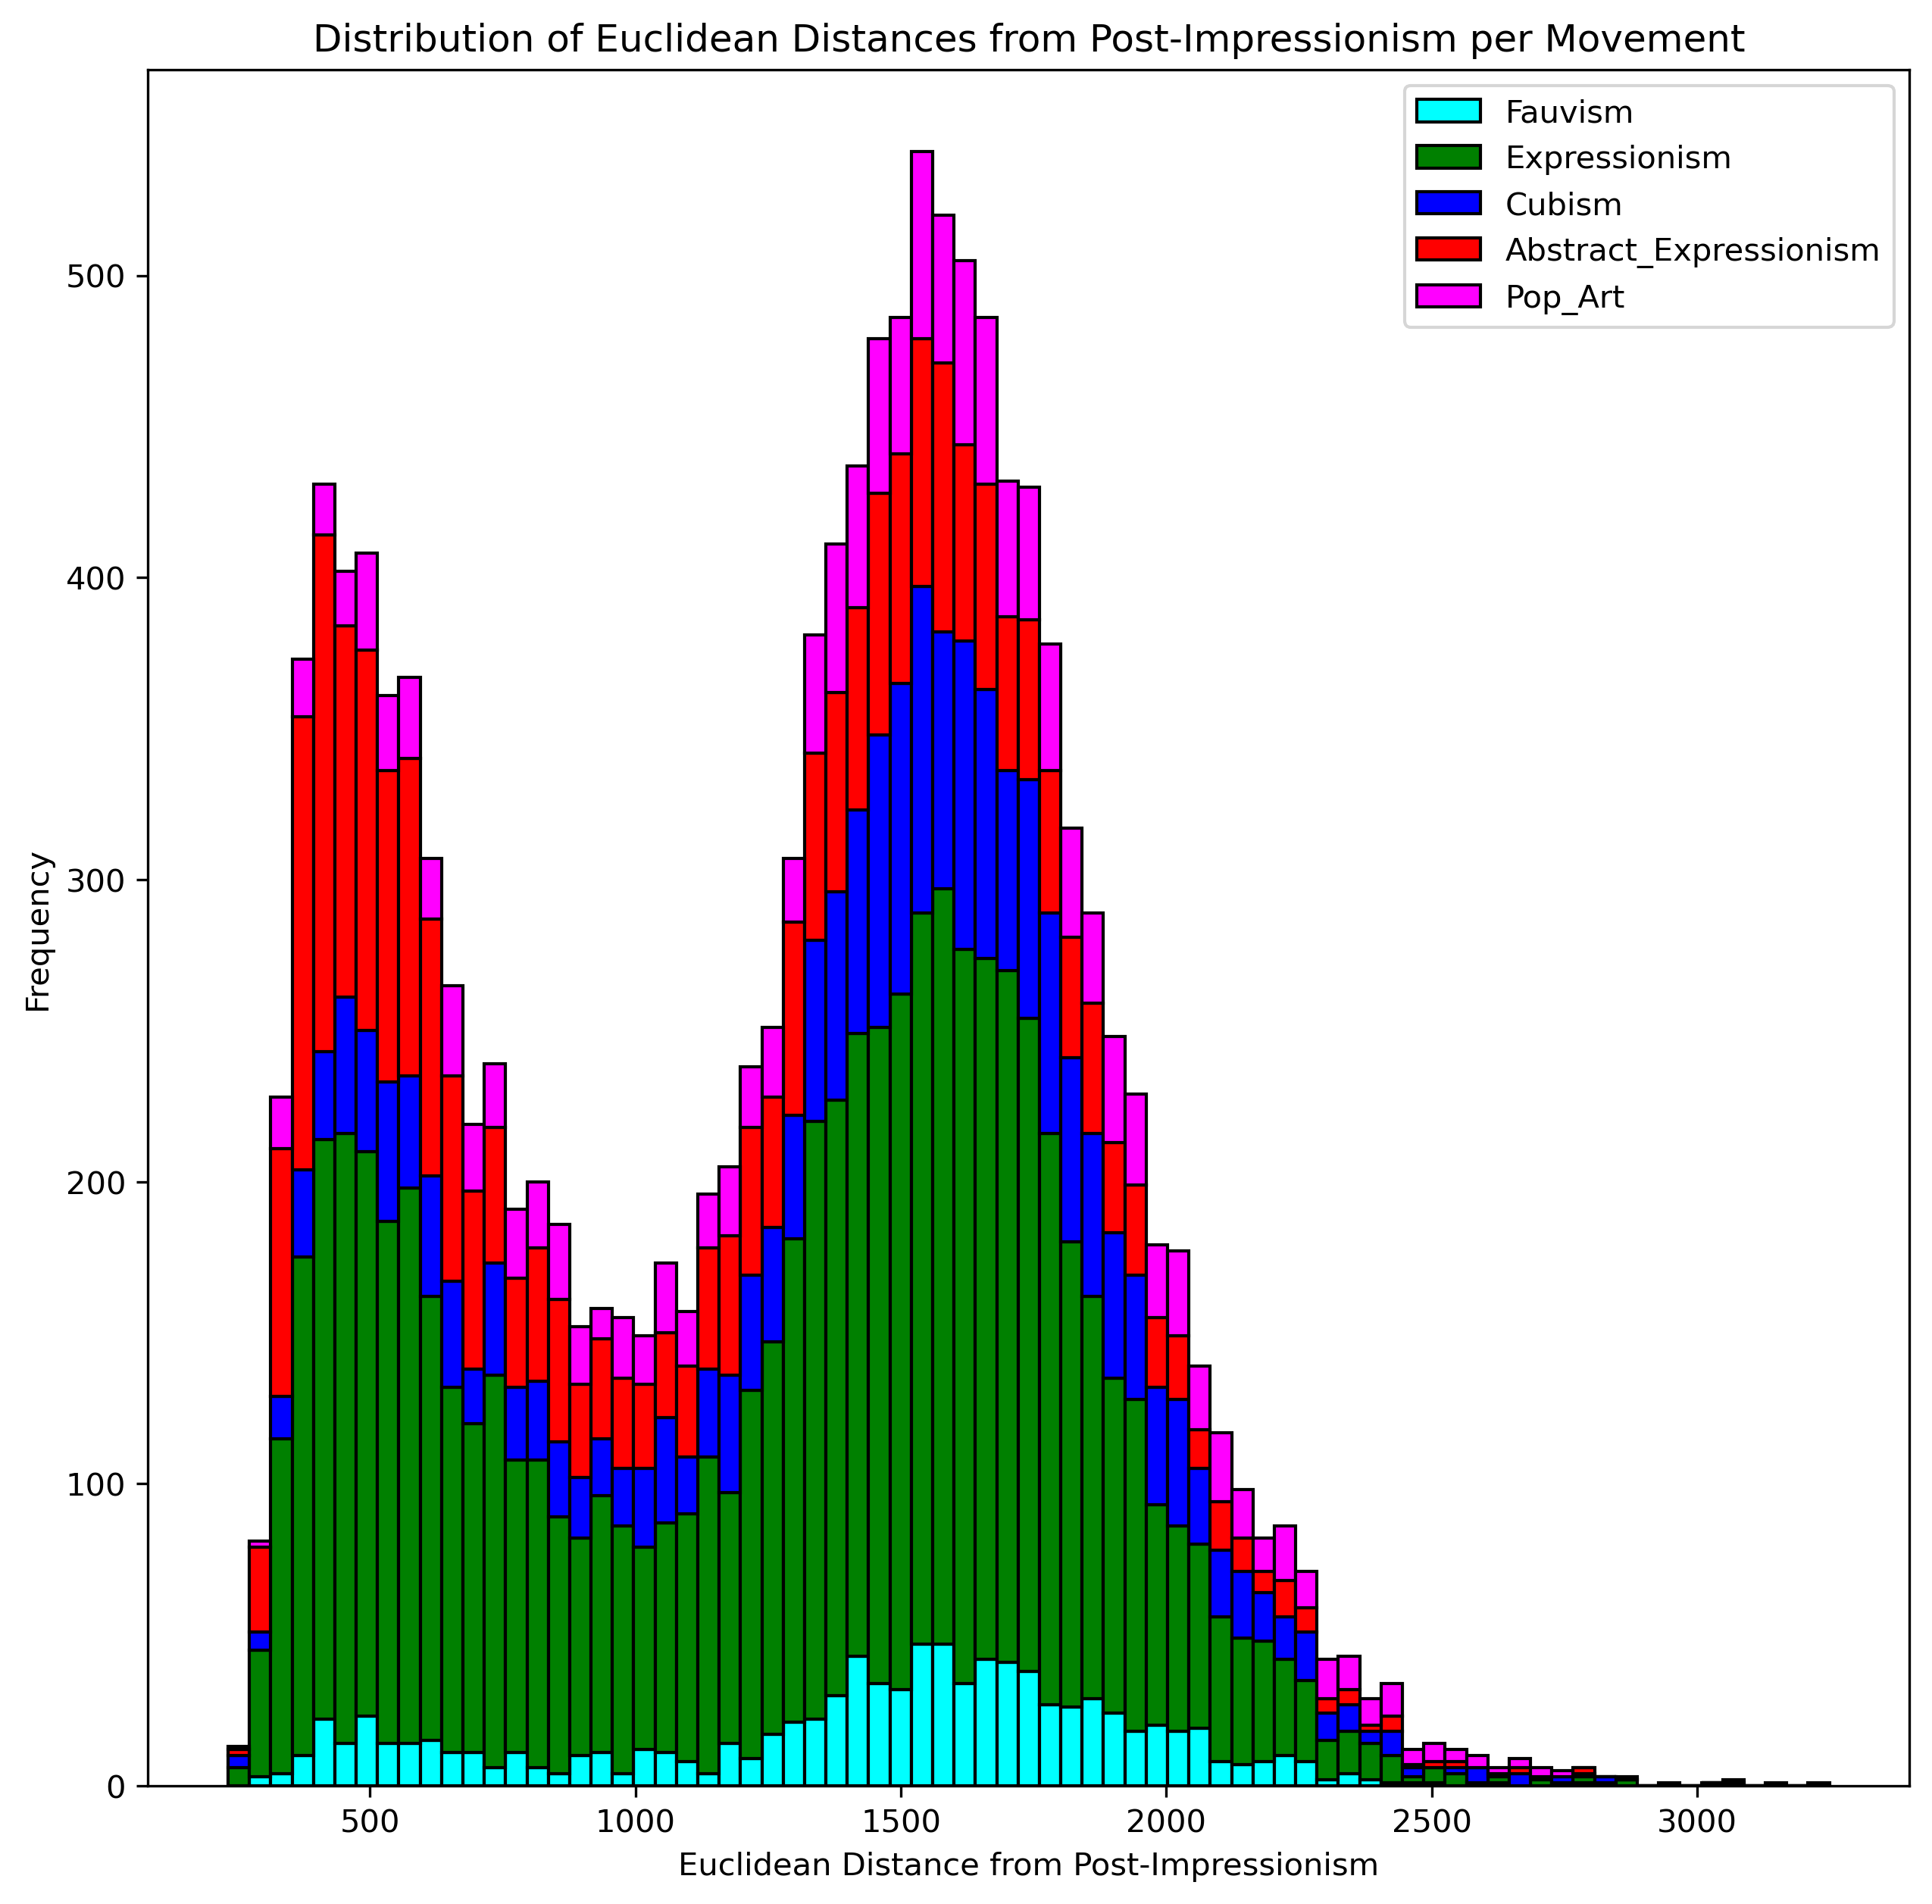

In [30]:
# Plot a stacked histogram for Euclidean distance
plt.figure(figsize=(10,10), dpi=300)
xs = []
label = []
for movement in range(len(chrono_movements)):
    
    # arrange movements in chronological order for better comparison between measurements
    index = list(class_names).index(chrono_movements[movement])
    data = movement_dist_eu[index]
    xs.append(data)
    label.append(class_names[index])
    
    
plt.hist(xs, bins = 75, color=colormap, edgecolor='black', label=label, histtype='barstacked', stacked=True)
plt.xlabel('Euclidean Distance from Post-Impressionism')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distances from Post-Impressionism per Movement')
plt.legend()

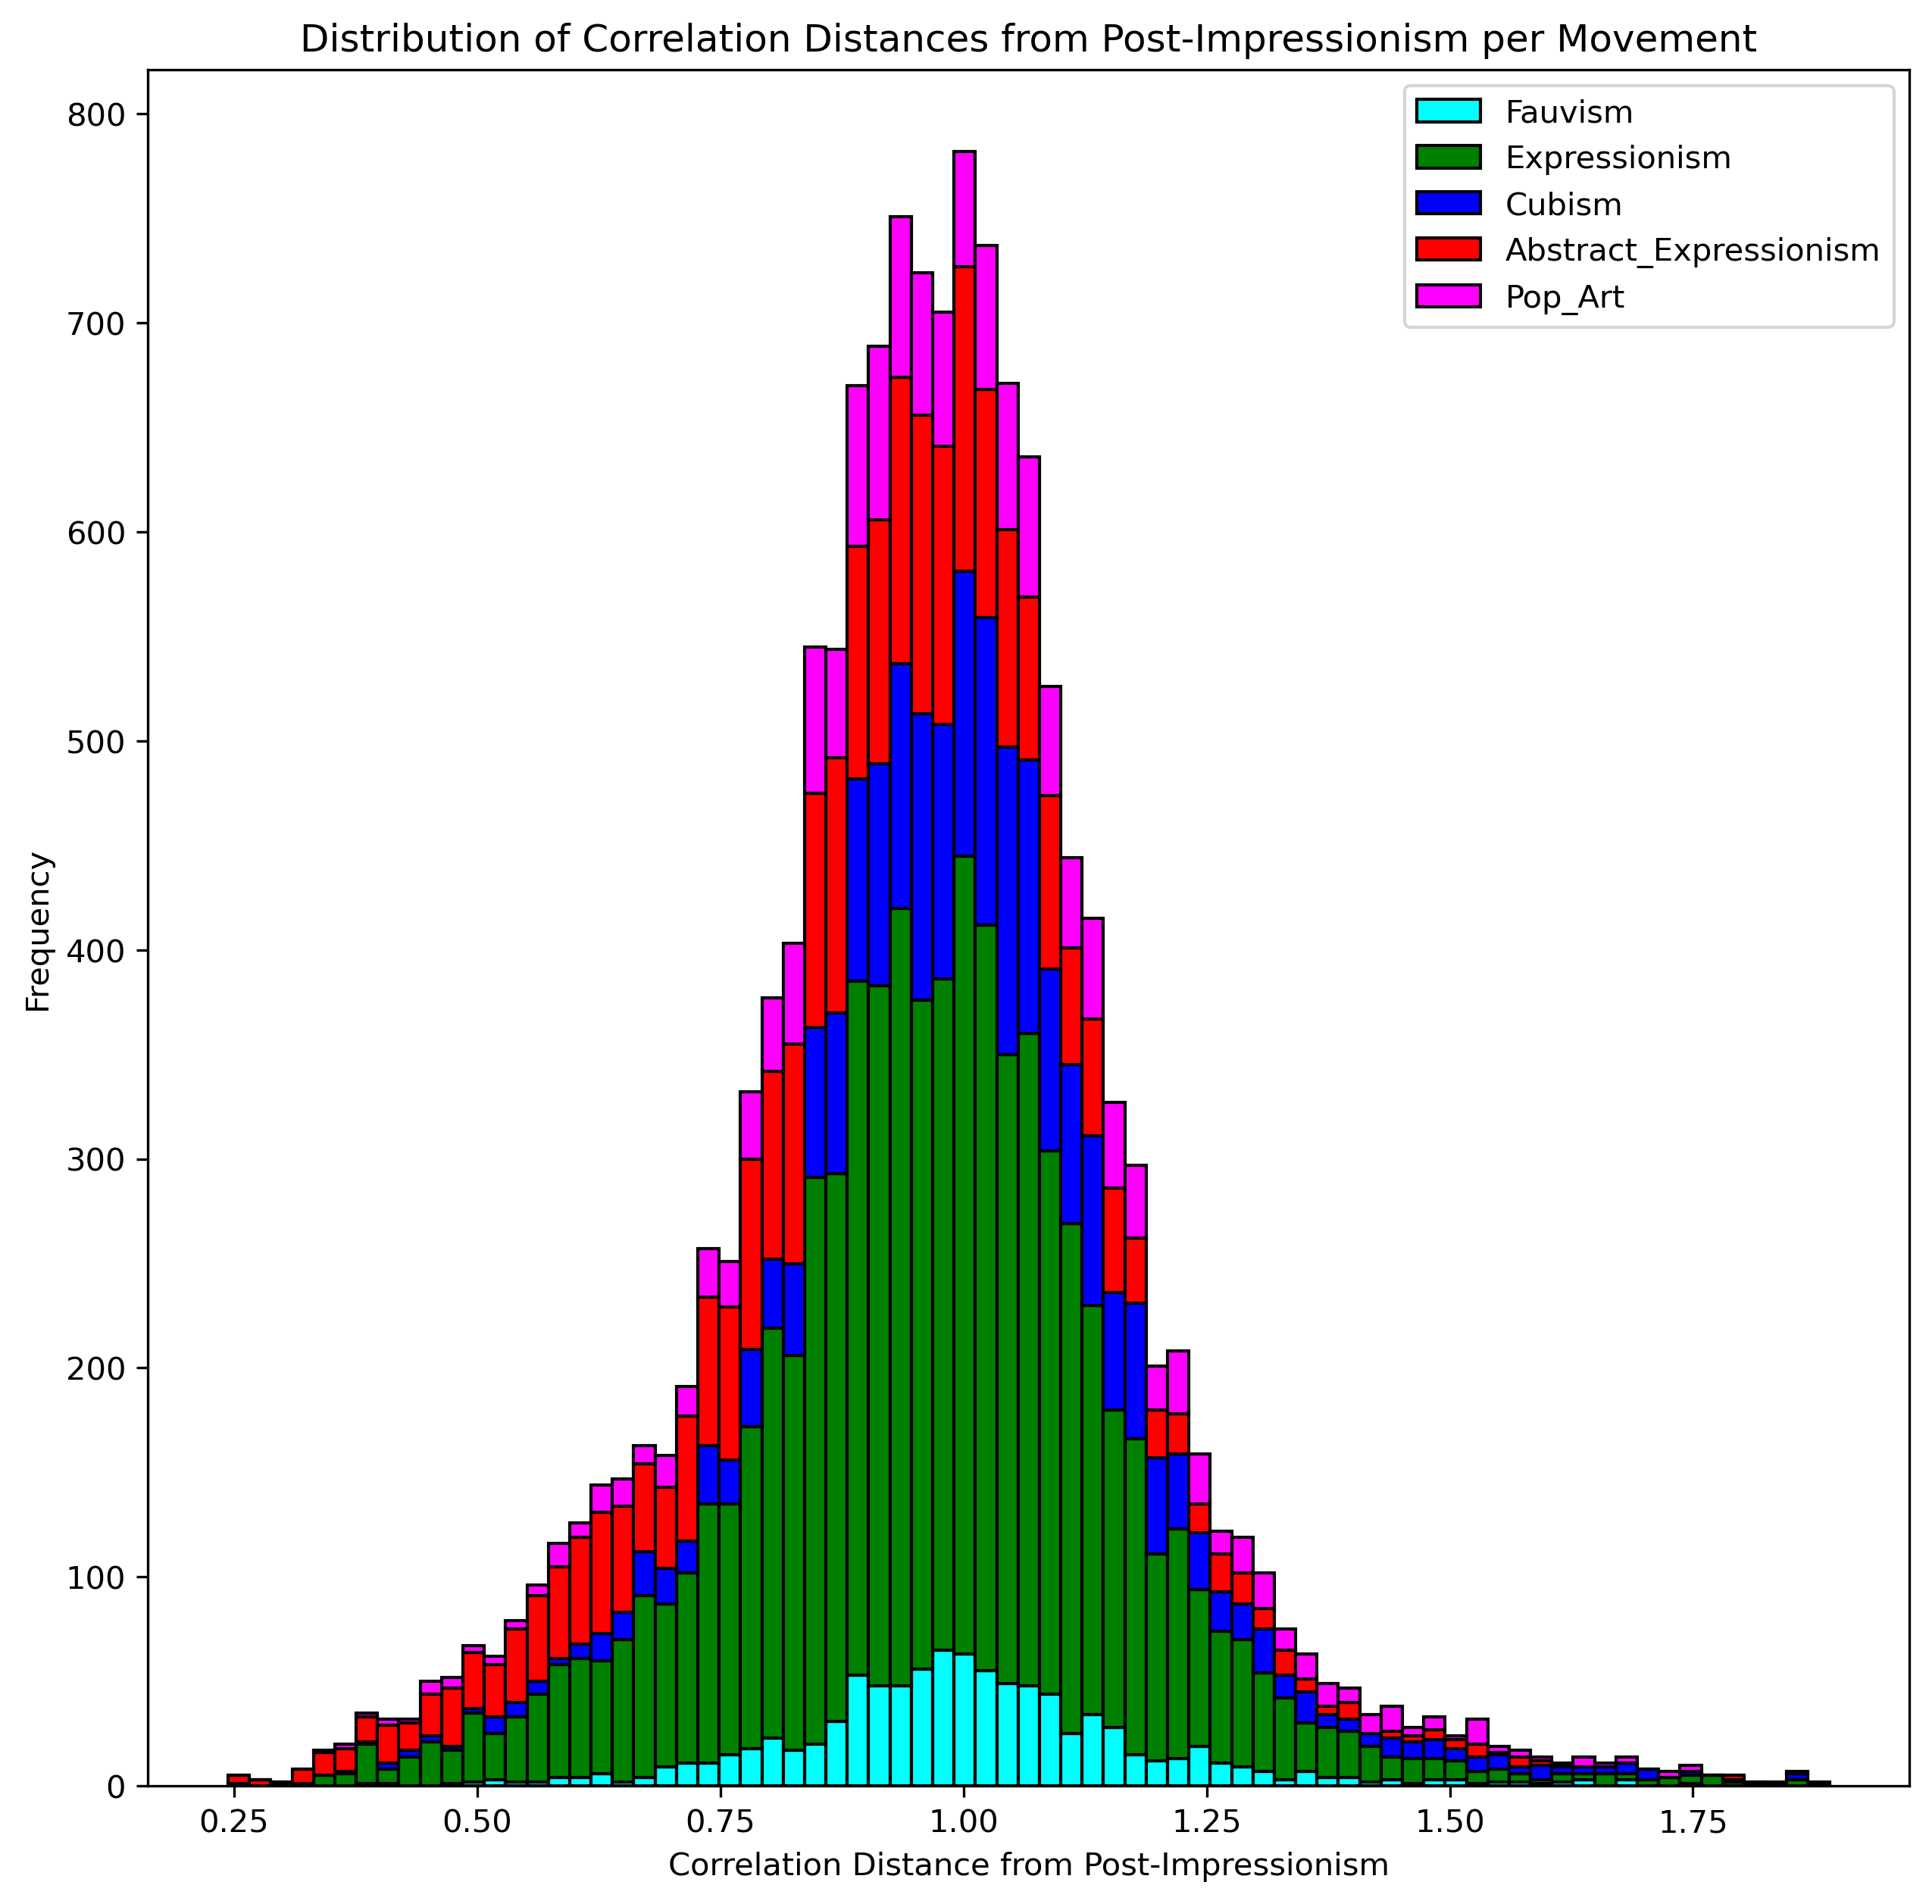

In [31]:
# Plot a stacked histogram for correlation distance
plt.figure(figsize=(10,10), dpi=300)
xs = []
label = []
for movement in range(len(movement_dist_corr.keys())):
    
    # arrange movements in chronological order for better comparison between measurements
    index = list(class_names).index(chrono_movements[movement])
    data = movement_dist_corr[index]
    xs.append(data)
    label.append(class_names[index])
    
    
plt.hist(xs, bins = 75, color=colormap, edgecolor='black', label=label, histtype='barstacked', stacked=True)
plt.xlabel('Correlation Distance from Post-Impressionism')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Distances from Post-Impressionism per Movement')
plt.legend()

The histograms were further visualised as density plots for ease of comparison of distributions between movements.

In [32]:
colormap = ['red', 'blue', 'green', 'cyan', 'magenta']

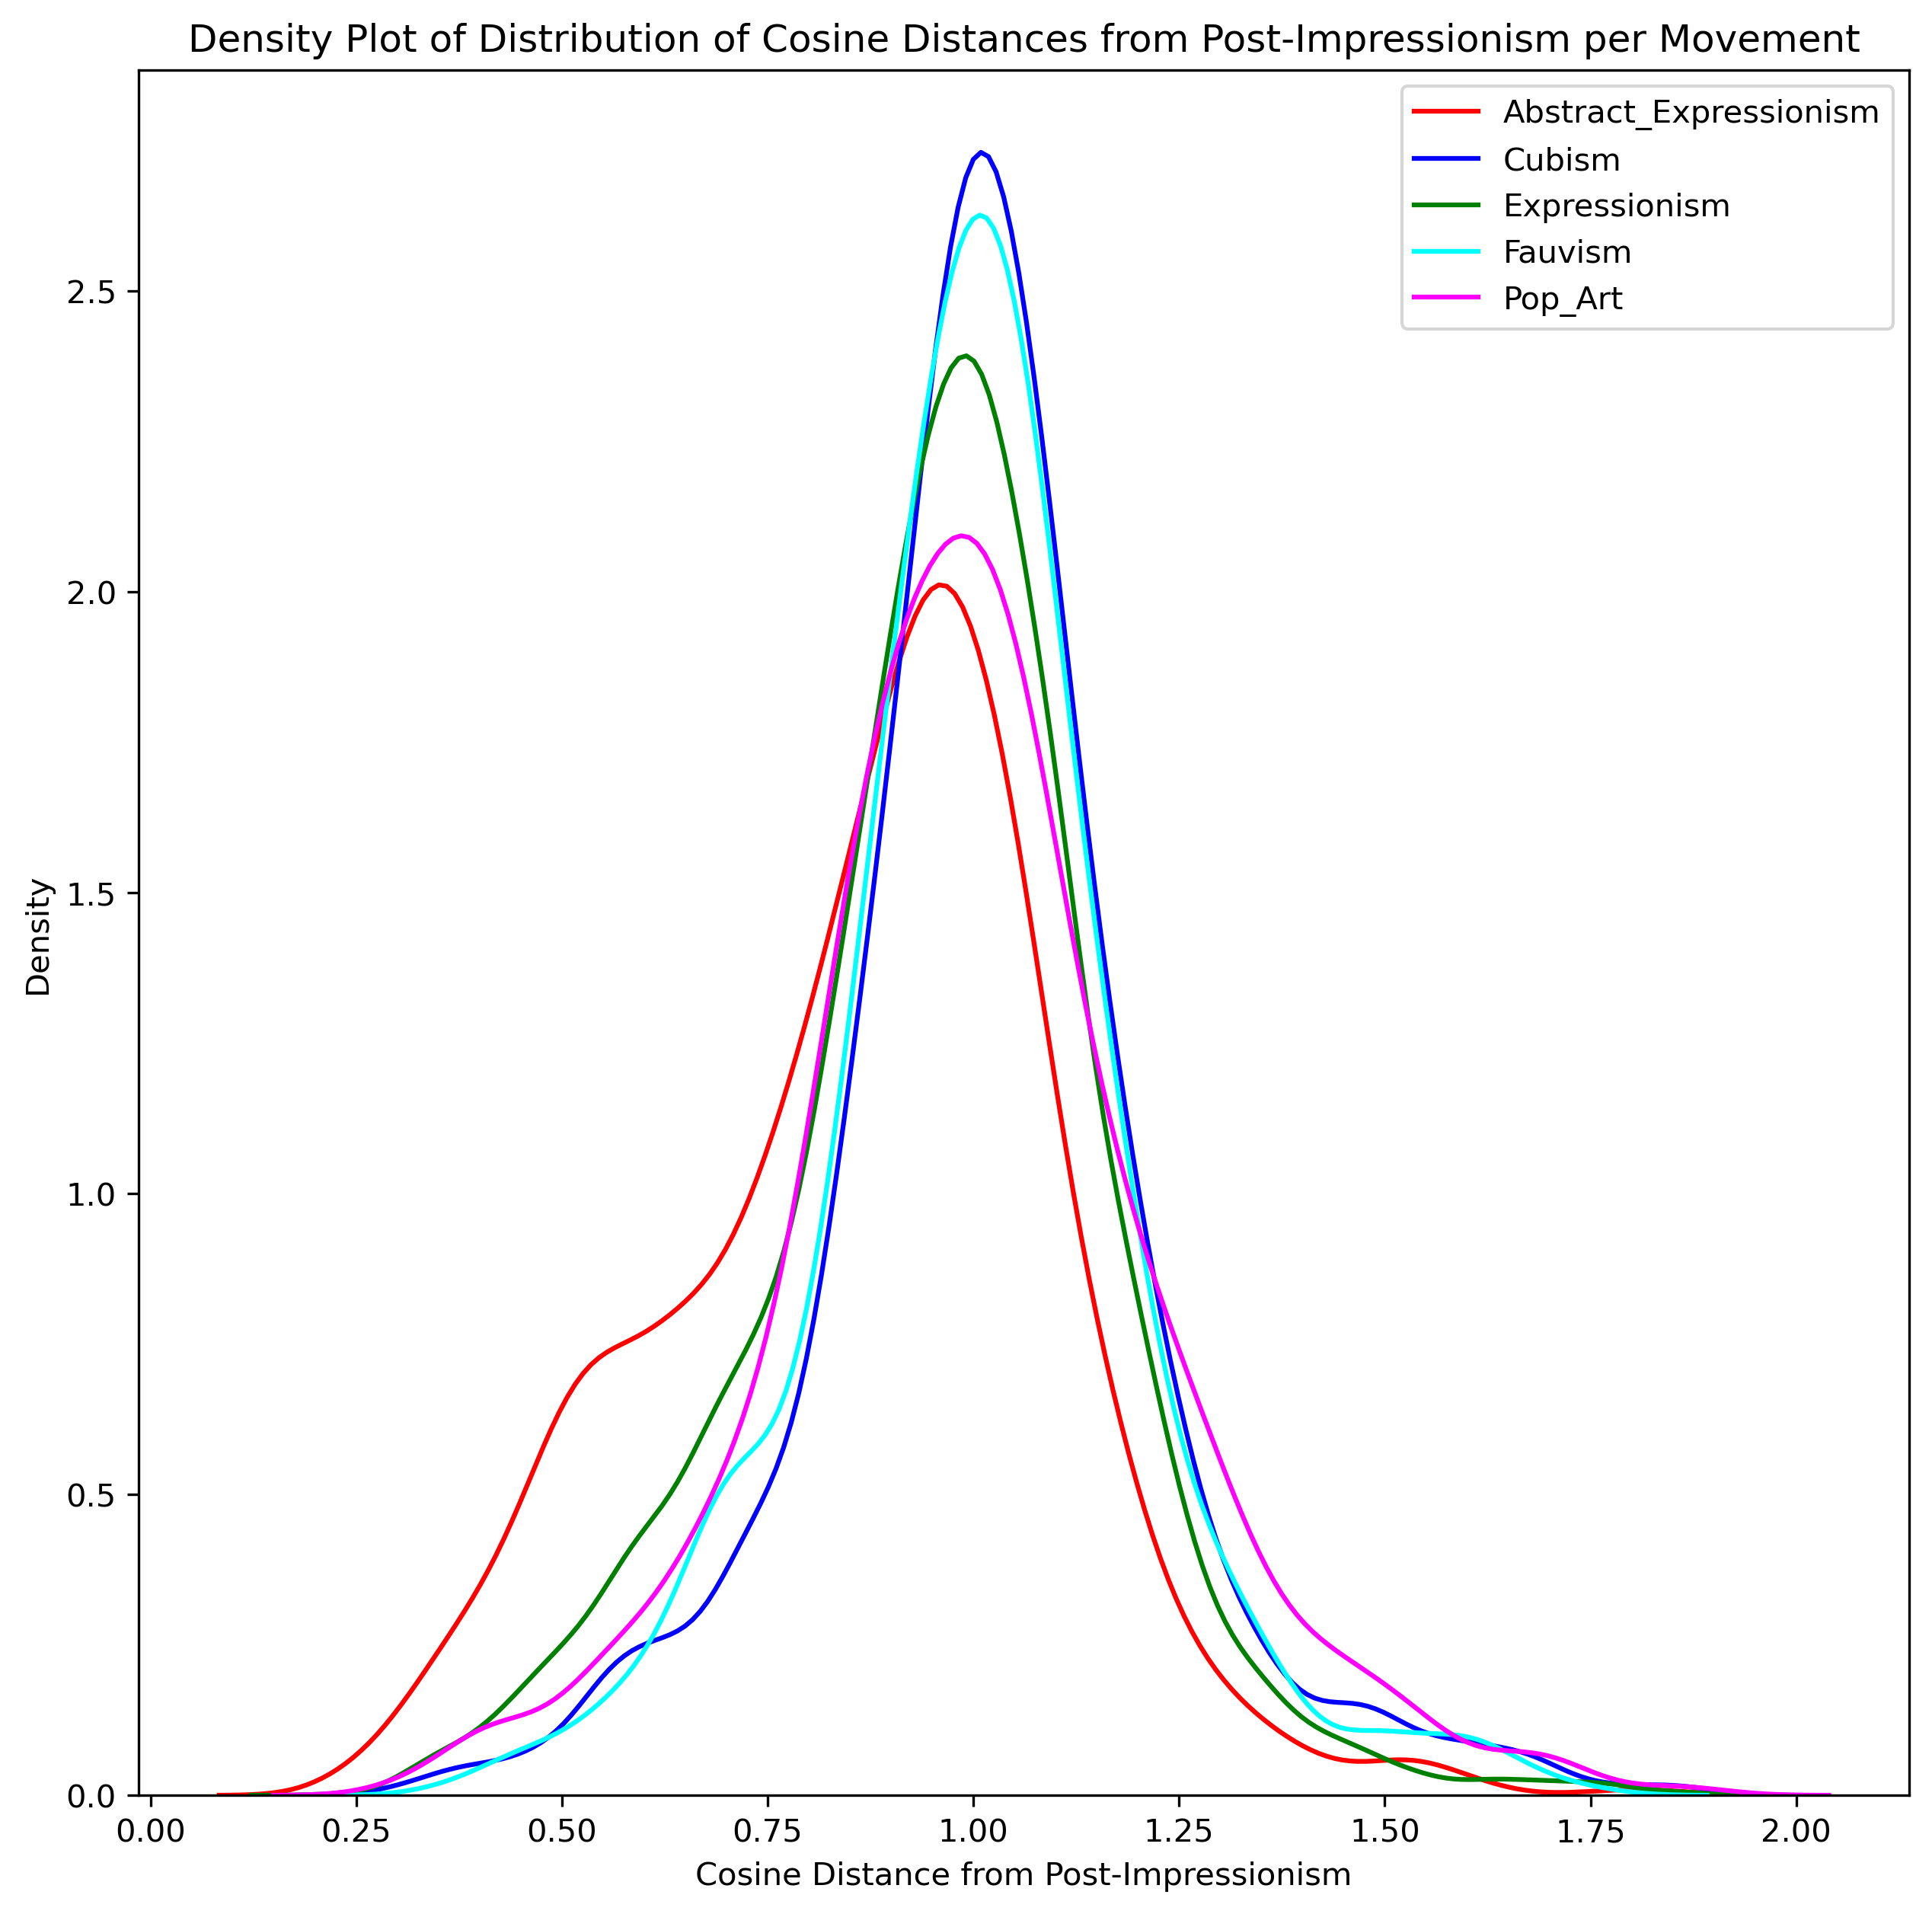

In [33]:
# For easier comparison plot density plot of graphs

# cosine distance
x = []
label = []
for movement in range(len(movement_dist_cos.keys())):
    data = movement_dist_cos[movement]
    x.append(data)
    label.append(class_names[movement])
    
plt.figure(figsize=(10,10), dpi=300)
for data in range(len(x)):
    fig = sea.kdeplot(x[data], color = colormap[data], label=class_names[data])
plt.title('Density Plot of Distribution of Cosine Distances from Post-Impressionism per Movement')
plt.xlabel('Cosine Distance from Post-Impressionism')
plt.legend()

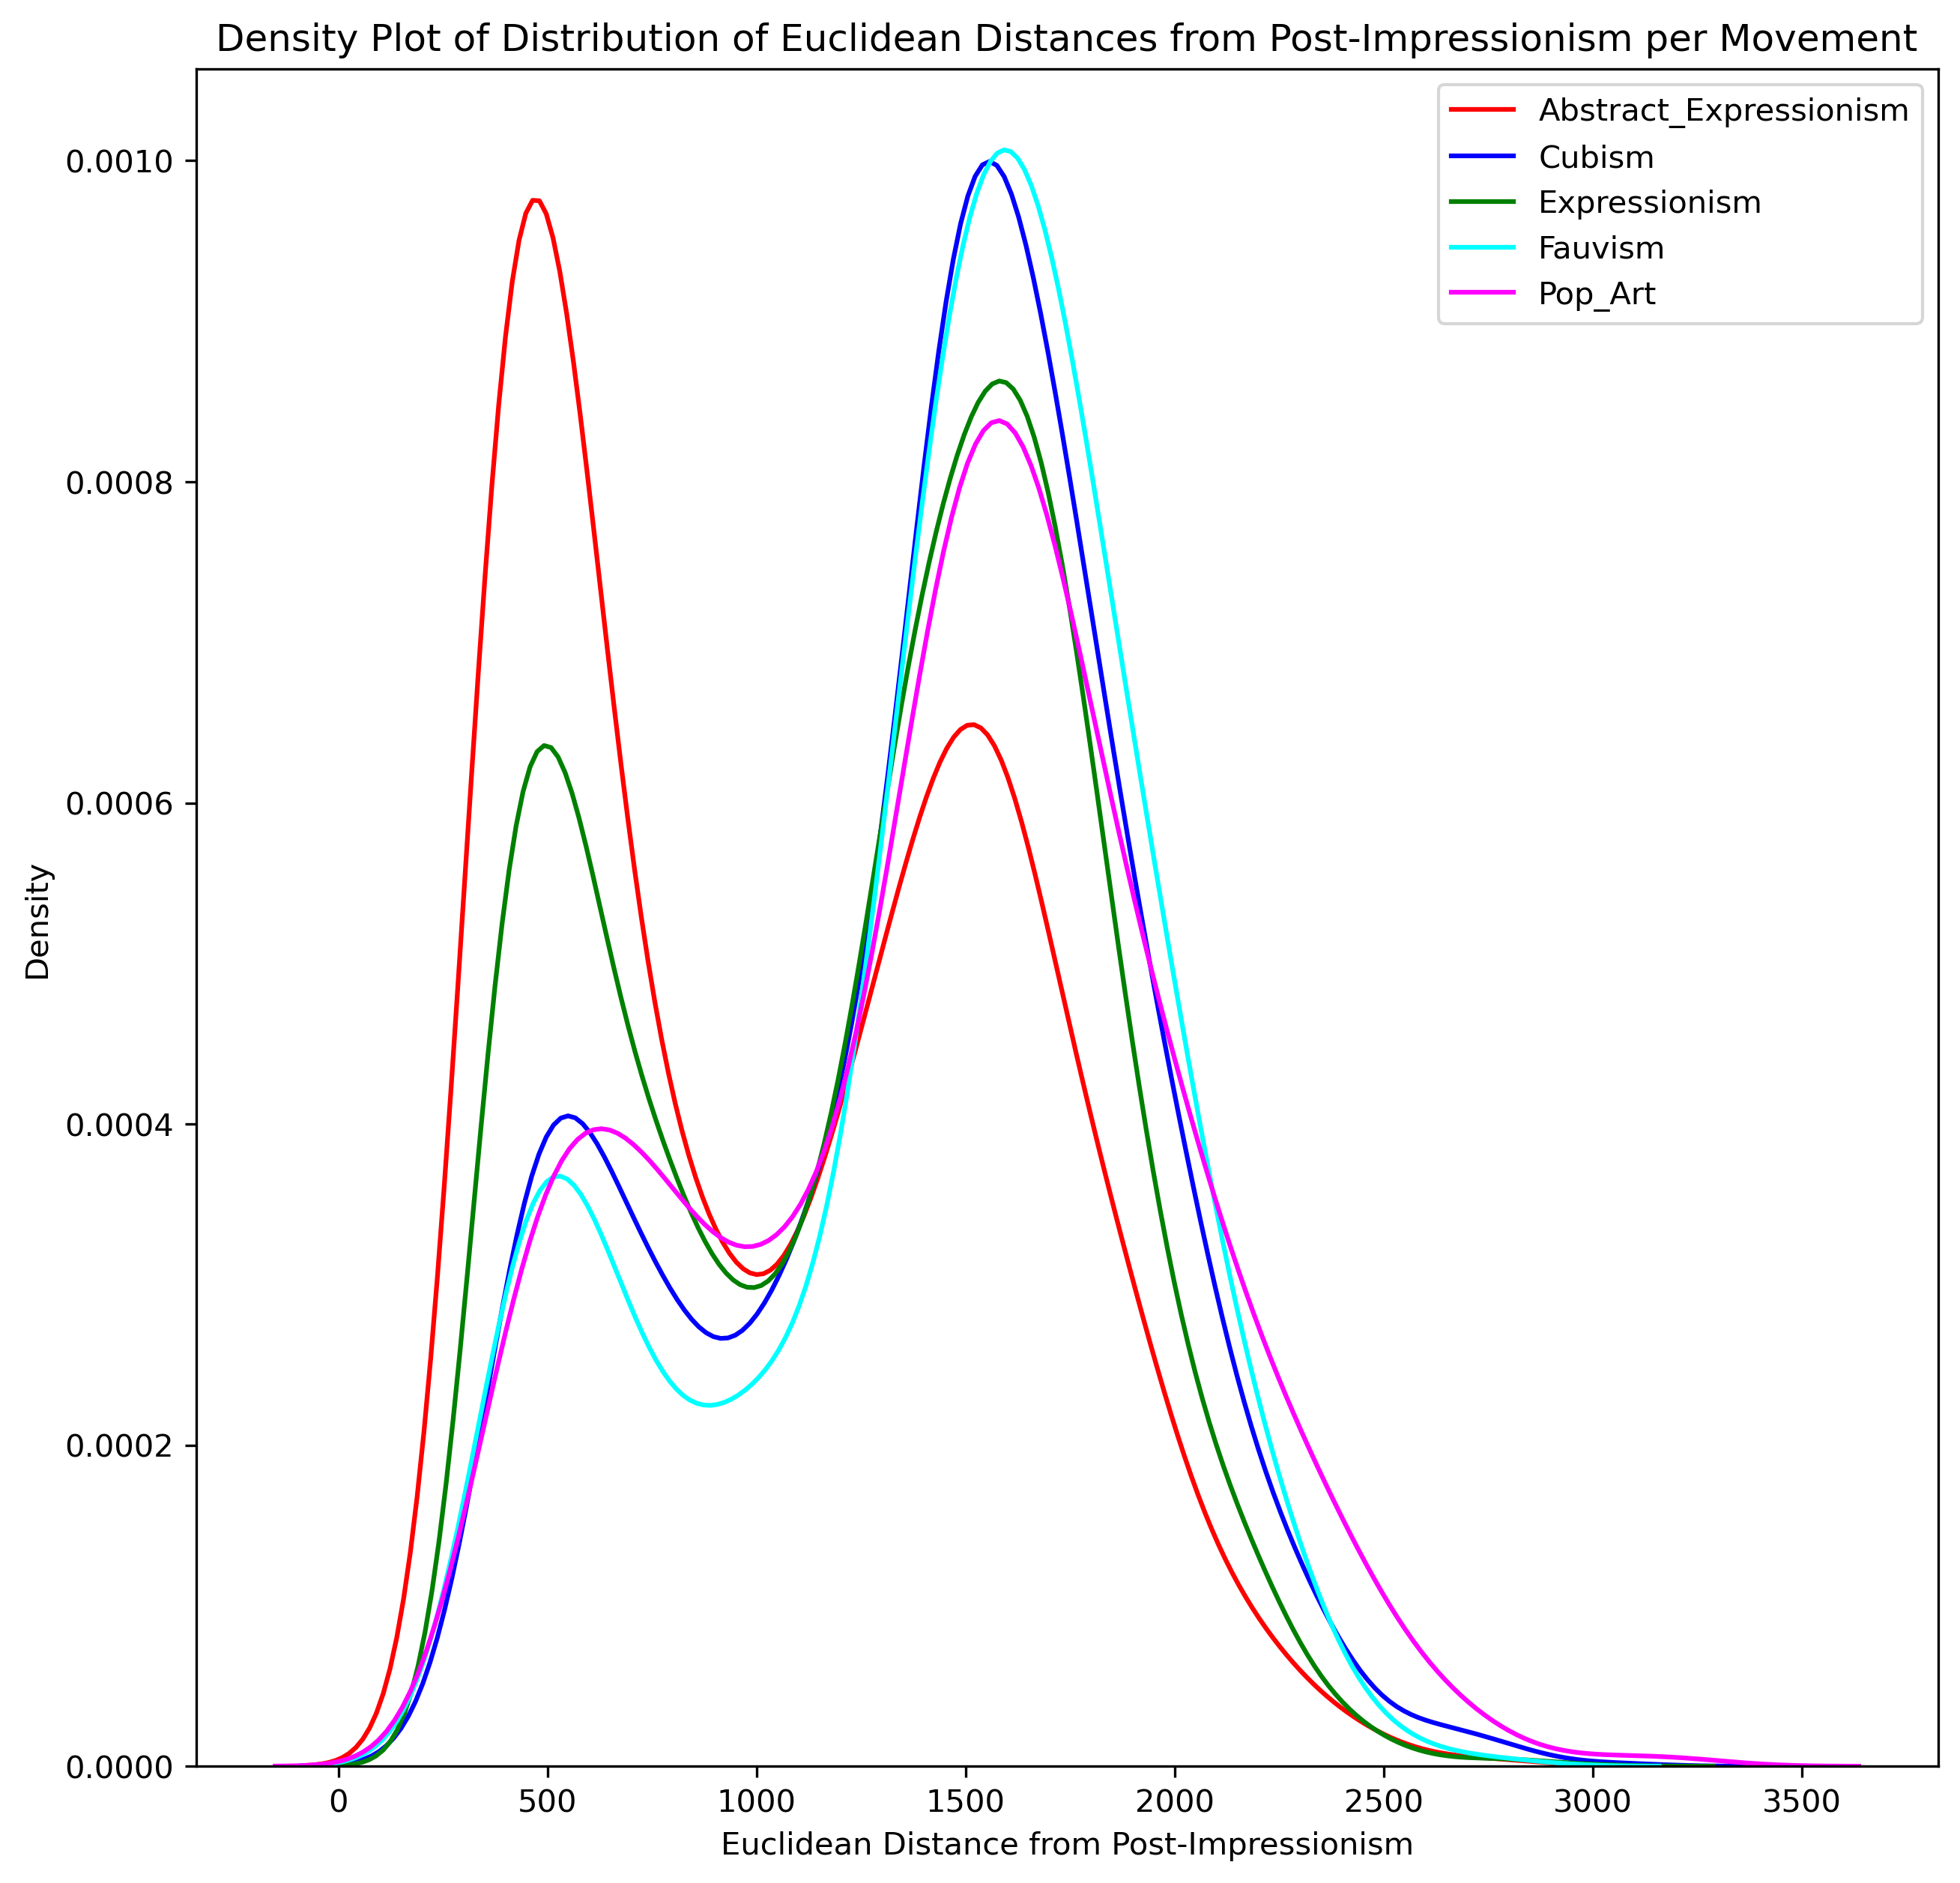

In [34]:
# euclidean distance
xs = []
for movement in range(len(movement_dist_cos.keys())):
    data = movement_dist_eu[movement]
    xs.append(data)
plt.figure(figsize=(10,10), dpi=300)
for data in range(len(xs)):
    fig = sea.kdeplot(xs[data], color = colormap[data], label=class_names[data])
plt.title('Density Plot of Distribution of Euclidean Distances from Post-Impressionism per Movement')
plt.xlabel('Euclidean Distance from Post-Impressionism')
plt.legend()

Presents a bimodal distribution but still retains the general trends displayed by cosine similarity.

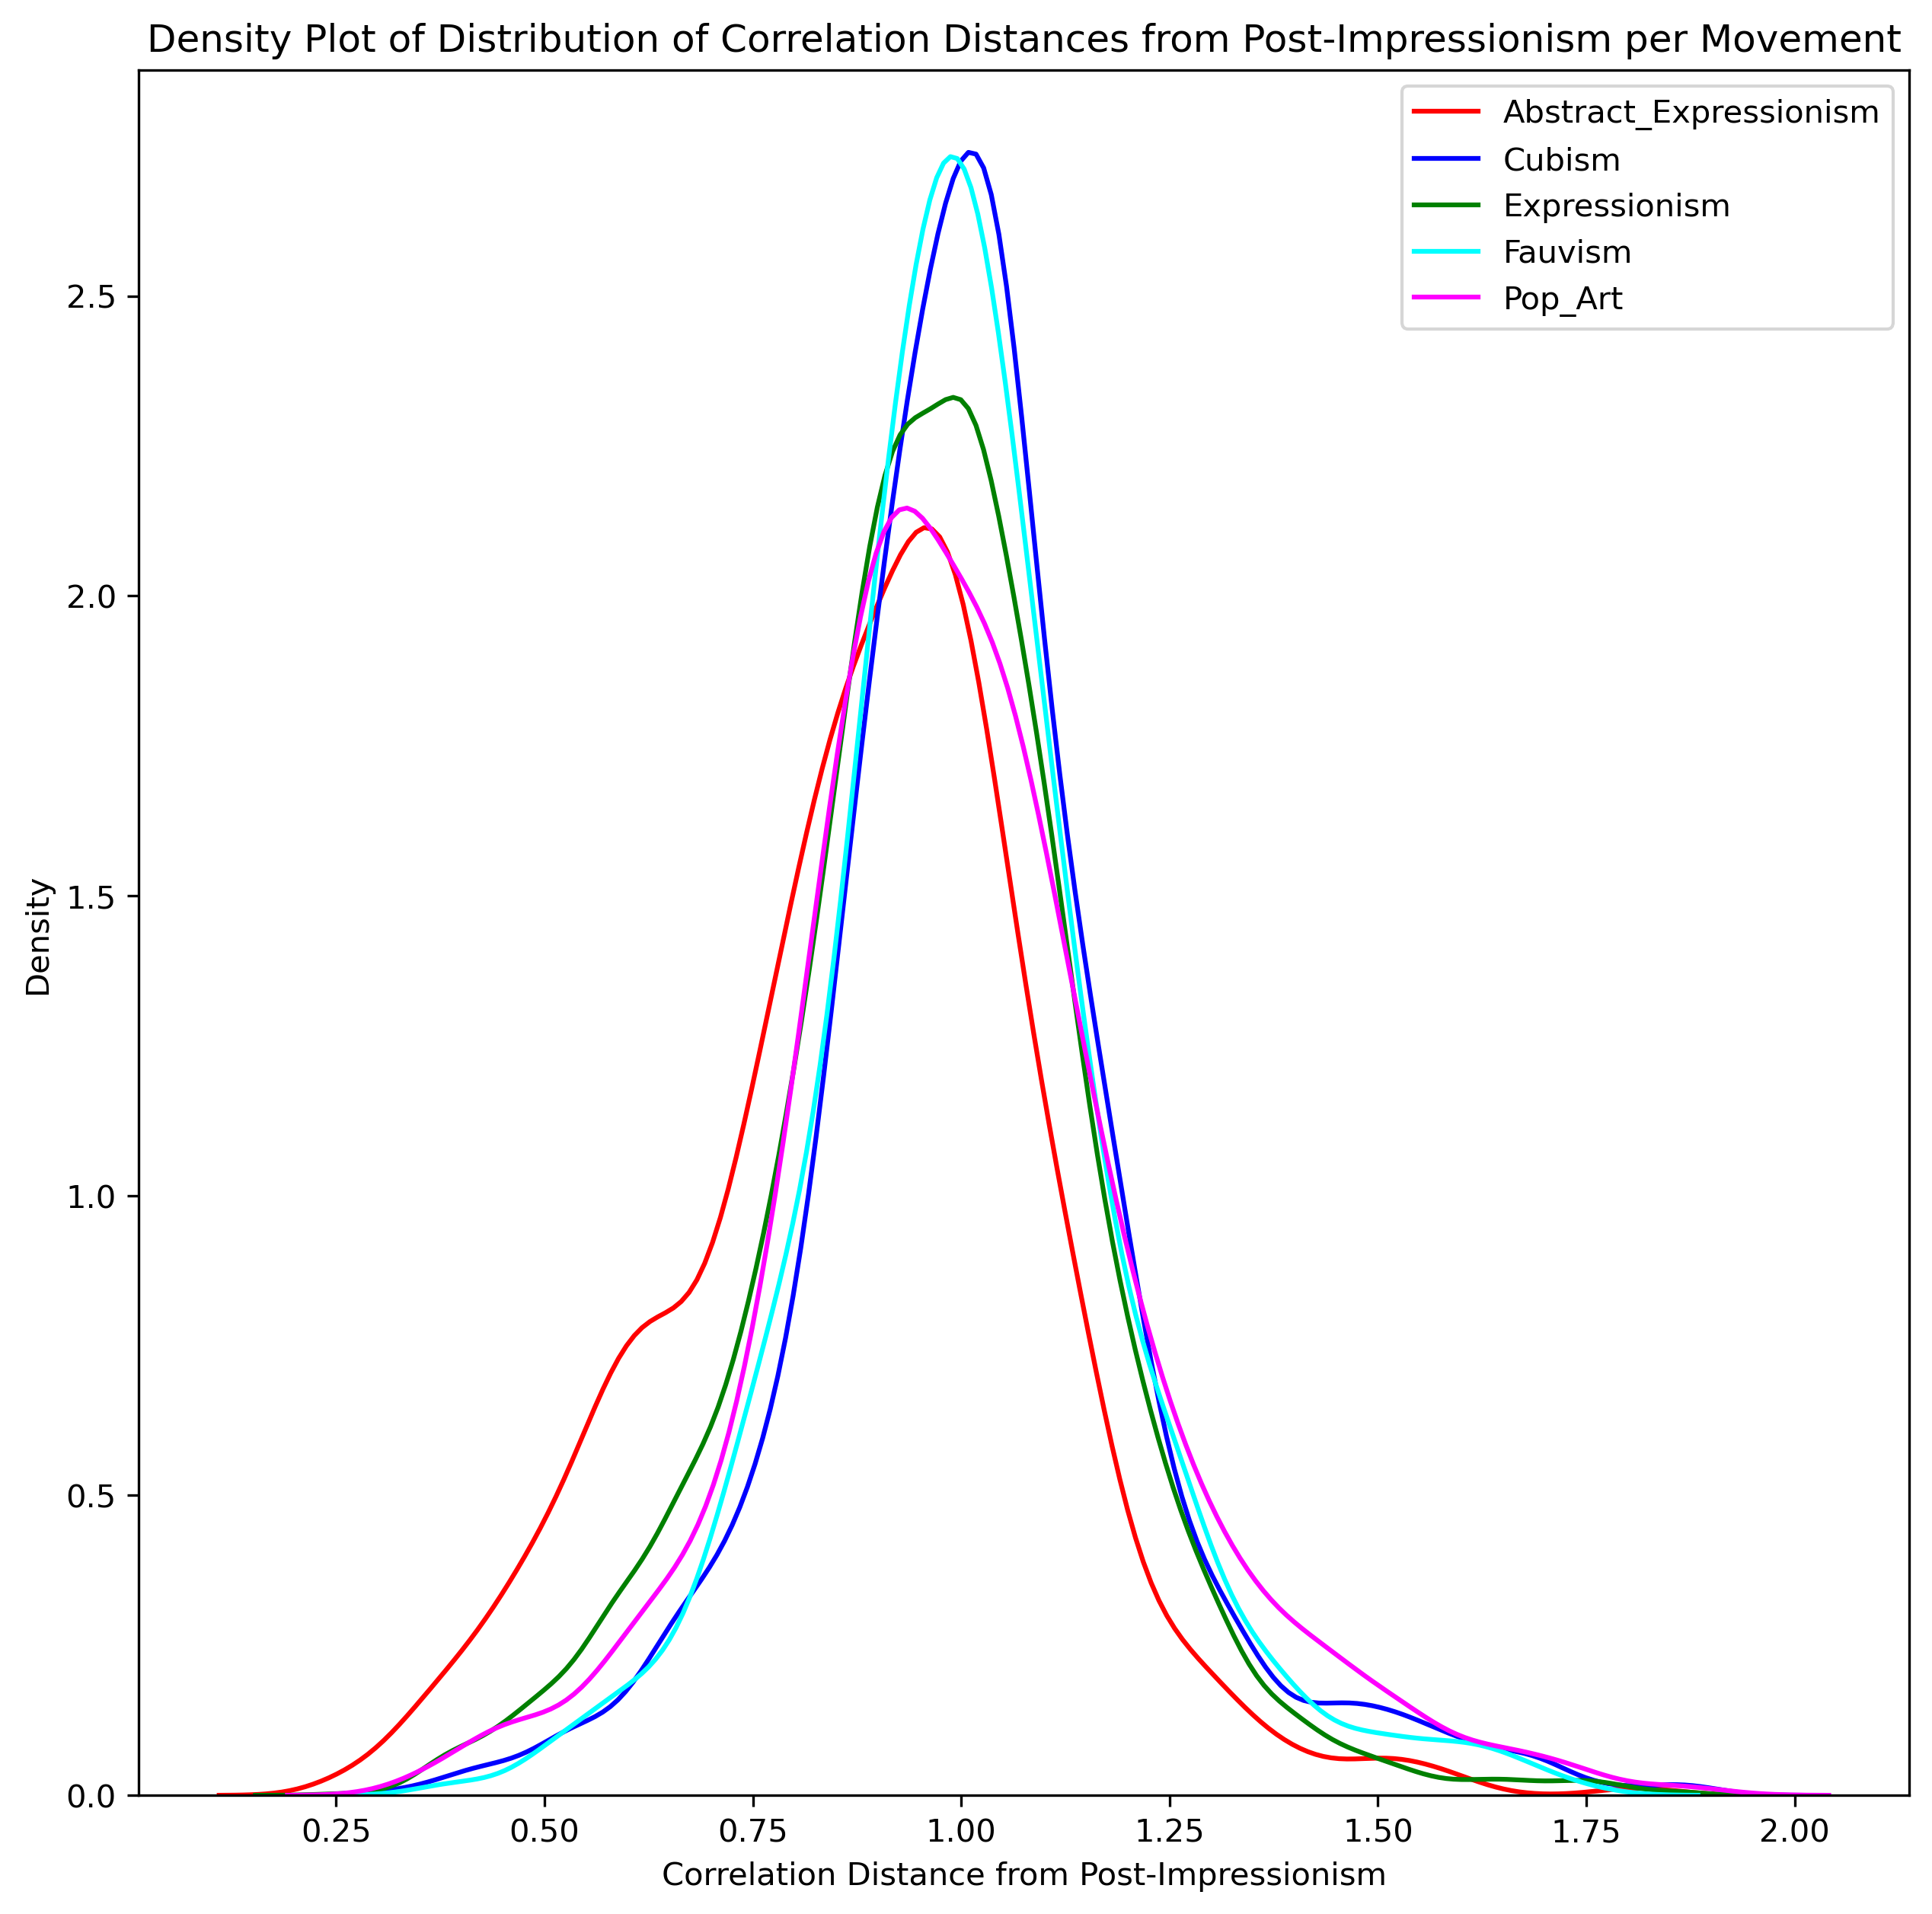

In [35]:
# correlation distance
xs = []
for movement in range(len(movement_dist_cos.keys())):
    data = movement_dist_corr[movement]
    xs.append(data)
plt.figure(figsize=(10,10), dpi=300)
for data in range(len(xs)):
    fig = sea.kdeplot(xs[data], color = colormap[data], label=class_names[data])
plt.title('Density Plot of Distribution of Correlation Distances from Post-Impressionism per Movement')
plt.xlabel('Correlation Distance from Post-Impressionism')
plt.legend()

## Closer inspection

The most similar and most dissimilar paintings to Post-Impressionism were identified for each distance measurement.

In [36]:
# Create a list of all painting distances per measurement
cosine_dist = []
for lst in movement_dist_cos.values():
    cosine_dist.extend(lst)
    
corr_dist = []
for lst in movement_dist_corr.values():
    corr_dist.extend(lst)

eu_dist = []
for lst in movement_dist_eu.values():
    eu_dist.extend(lst)

In [37]:
# Find the max and min values of these lists

# cosine
cosine_max = max(cosine_dist)
cosine_min = min(cosine_dist)

# correlation
corr_max = max(corr_dist)
corr_min = min(corr_dist)

# euclidean
eu_max = max(eu_dist)
eu_min = min(eu_dist)

Next the paintings at the extremes of the distributions were identified and visualized for each movement.

In [39]:
# for each movement get the most similar and most dissimilar paintings to Post-Impressionism

# cosine distance
cos_maxmin = {}
for movement in movement_dist_cos:
    cos_max = max(movement_dist_cos[movement])
    cos_min = min(movement_dist_cos[movement])
    max_idx = movement_dist_cos[movement].index(cos_max)
    min_idx = movement_dist_cos[movement].index(cos_min)
    mx = movements_dict[movement][max_idx]
    mn = movements_dict[movement][min_idx]
    cos_maxmin[movement] = [mx,mn]
    
# correlation distance
corr_maxmin = {}
for movement in movement_dist_corr:
    corr_max = max(movement_dist_corr[movement])
    corr_min = min(movement_dist_corr[movement])
    max_idx = movement_dist_corr[movement].index(corr_max)
    min_idx = movement_dist_corr[movement].index(corr_min)
    mx = movements_dict[movement][max_idx]
    mn = movements_dict[movement][min_idx]
    corr_maxmin[movement] = [mx,mn]
    
# euclidean distance
eu_maxmin = {}
for movement in movement_dist_eu:
    eu_max = max(movement_dist_eu[movement])
    eu_min = min(movement_dist_eu[movement])
    max_idx = movement_dist_eu[movement].index(eu_max)
    min_idx = movement_dist_eu[movement].index(eu_min)
    mx = movements_dict[movement][max_idx]
    mn = movements_dict[movement][min_idx]
    eu_maxmin[movement] = [mx,mn]
    

In [40]:
cos_maxmin

{2: [14265, 14110],
 0: [1302, 26],
 1: [10266, 15145],
 4: [5190, 12486],
 3: [16858, 2837]}

In [41]:
corr_maxmin

{2: [7651, 14110],
 0: [1302, 26],
 1: [10266, 15145],
 4: [5190, 3503],
 3: [16858, 2837]}

In [42]:
eu_maxmin

{2: [10120, 821],
 0: [14575, 15365],
 1: [15092, 2292],
 4: [14372, 20113],
 3: [11317, 16590]}

In [43]:
# functions to extract painting and artist name from filename

def get_artist(filename):
    
# A function that extracts the name of the artist from the filename of the painting 
    
    name = str(filename).split('\\')[-1].split('_')[-2].split('-')
    
    artist = name[-2].capitalize() + " " + name[-1].capitalize()
    
    return artist

def get_artwork(filename):
    
# A function that extracts the name of the painting from the filename of the painting 
    
    name = str(filename).split('\\')[-1].split('_')[-1].split('-')
    
    namewords = [word.capitalize() for word in name]
    
    artwork = ' '.join(namewords).strip(".jpg'")
    
    return artwork

In [44]:
# for each create a separate list or dict of their respective names, artists, and distances
# compile in table for paper

def get_info(maxmin_dict, dist_dict):
    
    # Prints details of most similar and most different paintings per movement 
    # with the max-min dictionary for each measurement as input
    
    movement_info = {}
    for movement in maxmin_dict:
        mx = maxmin_dict[movement][0]
        mn = maxmin_dict[movement][1]
        mx_info = 'Most Different - ' + get_artwork(filenames[mx]) + ', ' + get_artist(filenames[mx]) + ', ' + str(max(dist_dict[movement])) 
        mn_info = 'Most Similar - ' + get_artwork(filenames[mn]) + ', ' + get_artist(filenames[mn]) + ', ' + str(min(dist_dict[movement]))
        movement_info[movement] = [mn_info, mx_info]
    
    [print(class_names[movement], ": ", movement_info[movement][0], movement_info[movement][1]) for movement in maxmin_dict]
          

In [45]:
get_info(cos_maxmin, movement_dist_cos)

Expressionism :  Most Similar - Two Religious Figures, Salvador Dali, 0.2289574716925784 Most Different - She Flies Through The Air With The Greatest Of Ease, Miriam Schapiro, 1.855817323628604
Abstract_Expressionism :  Most Similar - Sunset, Cy Twombly, 0.22829717132451577 Most Different - Blue Sky Painting 1960, Sam Francis, 1.8513550042732796
Cubism :  Most Similar - The Gray Tree 1911, Piet Mondrian, 0.2977308671162292 Most Different - Factories 1918, Fernand Leger, 1.8773510633490536
Pop_Art :  Most Similar - Claude Monet, Tano Festa, 0.30752493832191585 Most Different - Desk Calendar 1962(1), Roy Lichtenstein, 1.8814048085001296
Fauvism :  Most Similar - Autumn Landscape 1905, De Vlaminck, 0.3622617691514115 Most Different - Still Life, Ion Pacea, 1.745871755305618


In [46]:
get_info(corr_maxmin, movement_dist_corr)

Expressionism :  Most Similar - Two Religious Figures, Salvador Dali, 0.2544848830485019 Most Different - Harlequin And Clown With Mask 1942, Rafael Zabaleta, 1.8629181859477393
Abstract_Expressionism :  Most Similar - Sunset, Cy Twombly, 0.24409865995111113 Most Different - Blue Sky Painting 1960, Sam Francis, 1.8453100133458649
Cubism :  Most Similar - The Gray Tree 1911, Piet Mondrian, 0.31908932892539277 Most Different - Factories 1918, Fernand Leger, 1.890324836567328
Pop_Art :  Most Similar - La Rotta Delle Rondini 1975, Tano Festa, 0.3448678098965299 Most Different - Desk Calendar 1962(1), Roy Lichtenstein, 1.8876815547562638
Fauvism :  Most Similar - Autumn Landscape 1905, De Vlaminck, 0.3870393754100617 Most Different - Still Life, Ion Pacea, 1.7435255016301836


In [47]:
get_info(eu_maxmin, movement_dist_eu)

Expressionism :  Most Similar - Trains Gorge Near Monstein 1920, Ludwig Kirchner, 232.91356489433178 Most Different - Girl With A Black Cat, Henri Matisse, 3011.566106217843
Abstract_Expressionism :  Most Similar - Jungle Night 1953, William Baziotes, 255.28700484661815 Most Different - Solstice 1946, Hans Hofmann, 2801.1040900413686
Cubism :  Most Similar - The Lamb 1914, Franz Marc, 252.8422093500126 Most Different - The Reaper On Red 1913, Kazimir Malevich, 3053.384241937603
Pop_Art :  Most Similar - Da Michelangelo 1978 1, Tano Festa, 236.0914354621012 Most Different - Roto Broil 1961(1), Roy Lichtenstein, 3248.833382233375
Fauvism :  Most Similar - Trees By The Gein At Moonrise 1908, Piet Mondrian, 295.04046300088834 Most Different - Three Dancers 1940, H. Johnson, 2774.555508011387


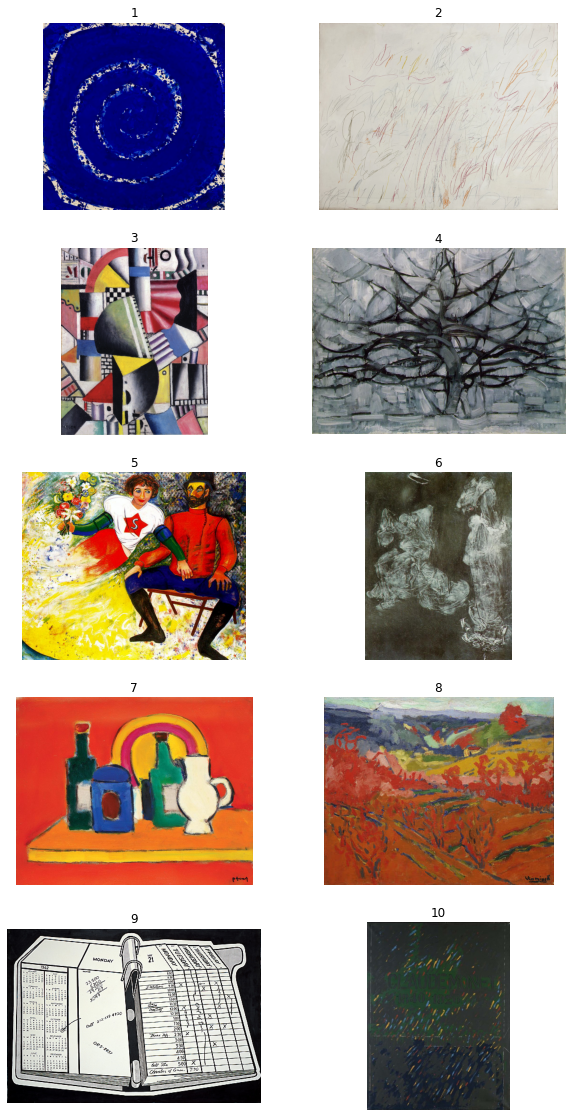

In [63]:
# visualize paintings at extremes of distributions for each movement

# cosine distance
plt.figure(figsize = (10,20))
pos_max = [1,3,5,7,9]
pos_min = [2,4,6,8,10]
for movement in cos_maxmin:
    plt.subplot(5,2, pos_max[movement])
    mx_file = filenames[cos_maxmin[movement][0]]
    mx_image = PIL.Image.open(mx_file)
    plt.imshow(mx_image)
    plt.axis('off')
    plt.title(pos_max[movement])
    
    plt.subplot(5,2, pos_min[movement])
    mn_file = filenames[cos_maxmin[movement][1]]
    mn_image = PIL.Image.open(mn_file)    
    plt.imshow(mn_image)
    plt.axis('off')
    plt.title(pos_min[movement])

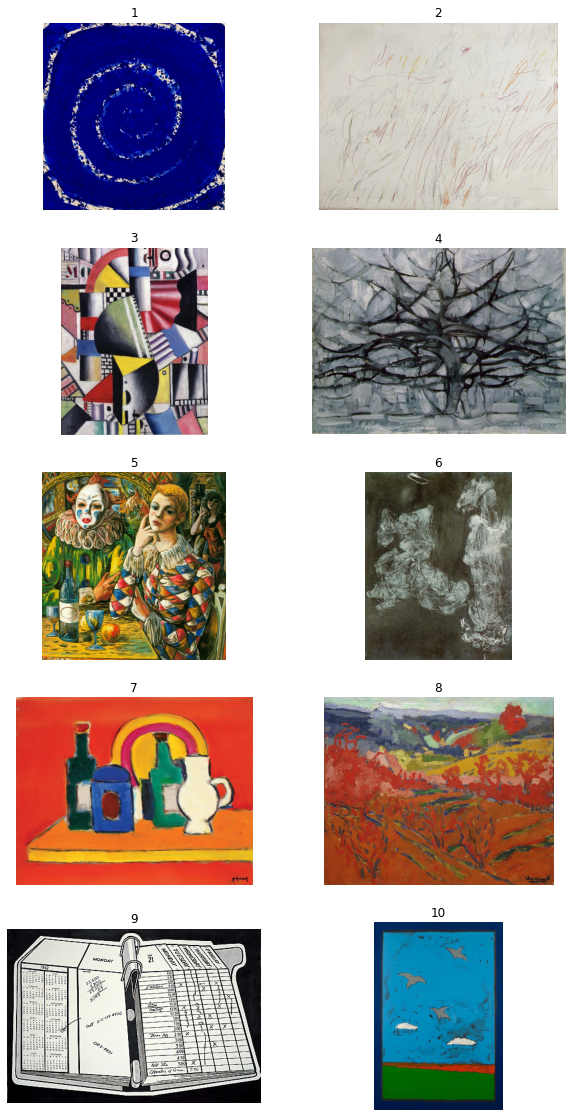

In [66]:
# correlation distance
plt.figure(figsize = (10,20))
for movement in corr_maxmin:
    plt.subplot(5,2, pos_max[movement])
    mx_file = filenames[corr_maxmin[movement][0]]
    mx_image = PIL.Image.open(mx_file)
    plt.imshow(mx_image)
    plt.axis('off')
    plt.title( pos_max[movement])
    plt.subplot(5,2, pos_min[movement])
    mn_file = filenames[corr_maxmin[movement][1]]
    mn_image = PIL.Image.open(mn_file)    
    plt.imshow(mn_image)
    plt.axis('off')
    plt.title(pos_min[movement])

The similarities between cosine and correlation distance distributions are displayed quite evidently here with nearly all the paintings at the extremes of each movement distributions being the same.

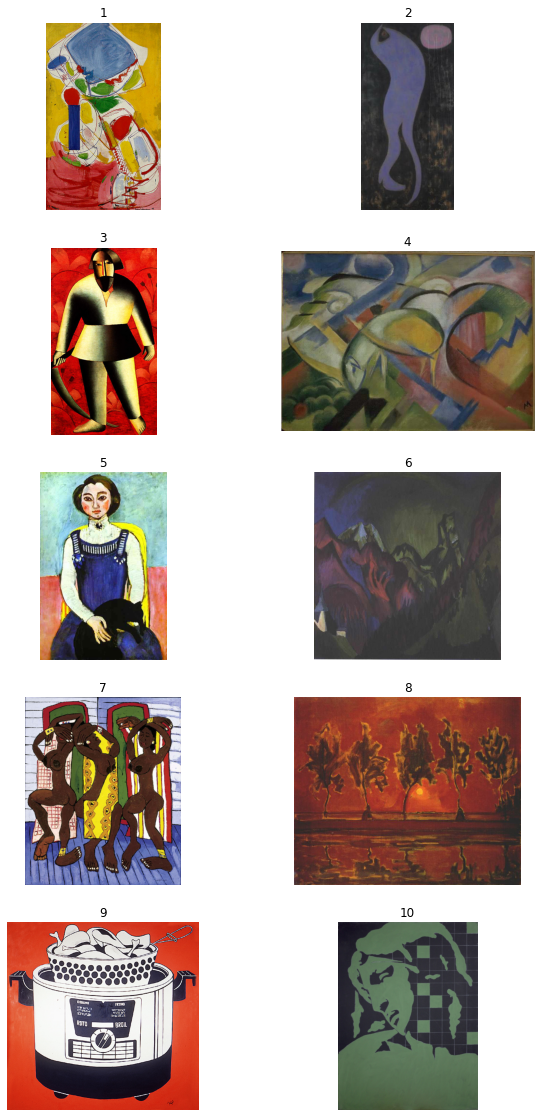

In [67]:
# Euclidean distance  
plt.figure(figsize = (10,20))
for movement in eu_maxmin:
    plt.subplot(5,2,pos_max[movement])
    mx_file = filenames[eu_maxmin[movement][0]]
    mx_image = PIL.Image.open(mx_file)
    plt.imshow(mx_image)
    plt.axis('off')
    plt.title(pos_max[movement])
    plt.subplot(5,2, pos_min[movement])
    mn_file = filenames[eu_maxmin[movement][1]]
    mn_image = PIL.Image.open(mn_file)    
    plt.imshow(mn_image)
    plt.axis('off')
    plt.title(pos_min[movement])

In terms of visual features at the extremes of these distributions, the most similar paintings in each movement tend towards more color gradation and expressive brushwork. The most different paintings to Post-Impressionism, however, seem to be defined by bold, well-defined lines and colors. Form is a great deal less concrete in the most similar paintings.

## Check results

The following is a check on the cosine distance measurement to ensure that the results measure the distance properly.

In [112]:
# Compare the distances of the following paintings to check that the vectors and the distances are representing the visual
# distances between paintings

# Painting from Post-Impressionism
"augustus-john_the-girl-on-the-cliff-1936"

# Two similar paintings from Cubism by the same artist
"fernand-leger_diver-on-a-yellow-background"
"fernand-leger_divers-polychrome"

# get index for these paintings
august = [art for art in movements_dict[5] if str(filenames[art]).split('\\')[-1] == "augustus-john_the-girl-on-the-cliff-1936.jpg'"]
fernand_1 = [art for art in movements_dict[1] if str(filenames[art]).split('\\')[-1] == "fernand-leger_diver-on-a-yellow-background.jpg'"]
fernand_2 = [art for art in movements_dict[1] if str(filenames[art]).split('\\')[-1] == "fernand-leger_divers-polychrome.jpg'"]    

<function matplotlib.pyplot.show(close=None, block=None)>

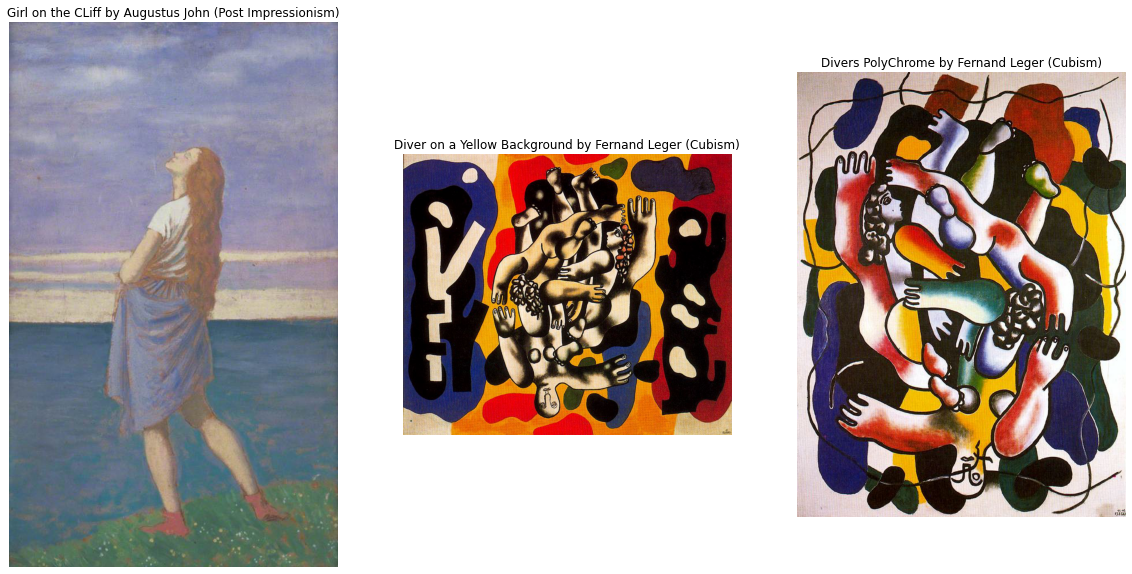

In [113]:
# load images to demonstrate their visual closeness
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
image = PIL.Image.open(filenames[august[0]])
plt.title("Girl on the CLiff by Augustus John (Post Impressionism)")
plt.imshow(image)
plt.axis("off")
plt.show
plt.subplot(1,3,2)
image = PIL.Image.open(filenames[fernand_1[0]])
plt.title("Diver on a Yellow Background by Fernand Leger (Cubism)")
plt.imshow(image)
plt.axis("off")
plt.show
plt.subplot(1,3,3)
image = PIL.Image.open(filenames[fernand_2[0]])
plt.title("Divers PolyChrome by Fernand Leger (Cubism)")
plt.imshow(image)
plt.axis("off")
plt.show

In [114]:
aug = featurevecs[august[0]]
f1 = featurevecs[fernand_1[0]]
f2 = featurevecs[fernand_2[0]]
f1_f1_cos = distance.cosine(f1, f1)
f1_f2_cos = distance.cosine(f1, f2)
aug_f1_cos = distance.cosine(aug,f1)
aug_f2_cos = distance.cosine(aug, f2)


In [116]:
print(f1_f1_cos, f1_f2_cos, aug_f1_cos, aug_f2_cos)

0 0.6919148470678056 1.2638642840177132 1.1303804696100213
